# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from bert.tokenization import FullTokenizer

# from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import BertLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_bert, initialize_vars
from models.train_models import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
# some constants
RDM_SEED = 1
K_FOLDS = 5
MAX_SEQ_LEN = 30

In [8]:
def proc_sentences(df, col_sentence, col_targ):
    sentences = []
    li_targ = []
    li_sent = []
    for i in range(df.shape[0]):
        sent = df[col_sentence][i]
        targ = None
        if(col_targ):
            targ = df[col_targ][i]
        else:
            targ = "[MASK]"
        sent = sent.replace("______", targ)
        li_targ.append(targ)
        li_sent.append(sent)
    sentences = [np.array(li_targ), np.array(li_sent)]
    return(sentences)

sentences = proc_sentences(df_cloze, 'sentence', 'targ')

In [9]:
# sentences_wttarg = proc_sentences(df_cloze, 'sentence', 'syn1')
# sentences_notarg = proc_sentences(df_cloze, 'sentence', None)
sentences = proc_sentences(df_cloze, 'sentence', 'targ')

In [10]:
sentences

[array(['discord', 'rakish', 'defile', ..., 'deviate', 'frigid', 'adhere'],
       dtype='<U12'),
 array([' A discord  emerged between the two who were once friends . ',
        ' A bohemian is a person who is free-spirited and rakish  . ',
        ' A bunch of kids had broken in and defile  the paintings . ', ...,
        ' You will not get lost if you stay straight and do not deviate  . ',
        " You'll find what you're looking for when it becomes more frigid  . ",
        " Your plan's nice, but I doubt I could adhere  to it for long . "],
       dtype='<U109')]

In [11]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_brt = resp_scores[:, 1]
resp_lmo = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


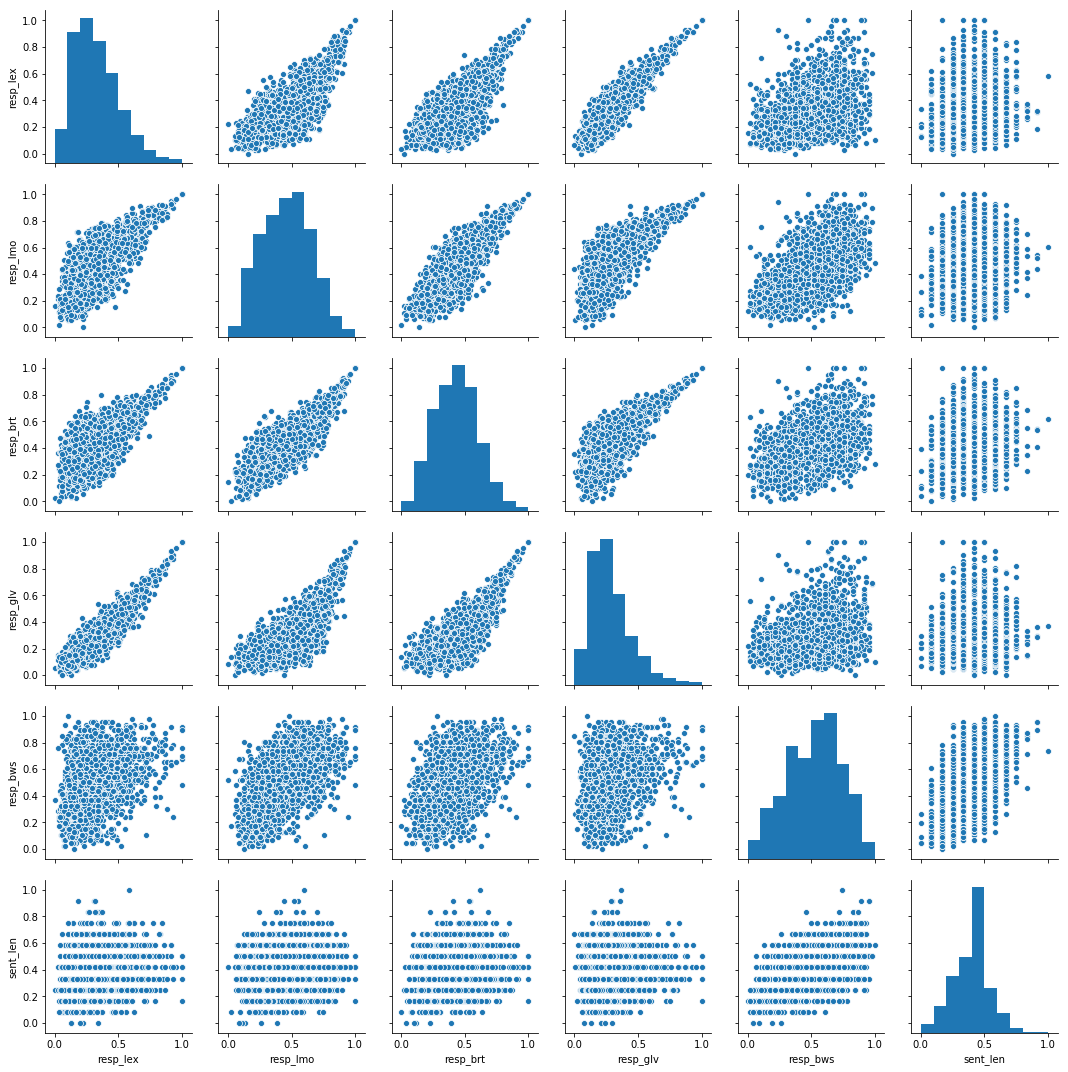

In [12]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

In [13]:
tokenizer = create_tokenizer_from_hub_module()
train_examples = convert_text_to_examples(sentences[0], sentences[1], resp_bws)
tt = convert_examples_to_features(tokenizer, train_examples[:1], True, MAX_SEQ_LEN)
tt[:4]

(array([[  138, 19959,  2956,  5338,  1206,  1103,  1160,  1150,  1127,
          1517,  2053,   119,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]),
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]))

# BERT + Attention model

In [14]:
K.clear_session()
sess = tf.Session()

model = build_model_bert(MAX_SEQ_LEN, attention_layer=True)
initialize_vars(sess)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_tloc (InputLayer)         [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
______________________________________________________________________________________________

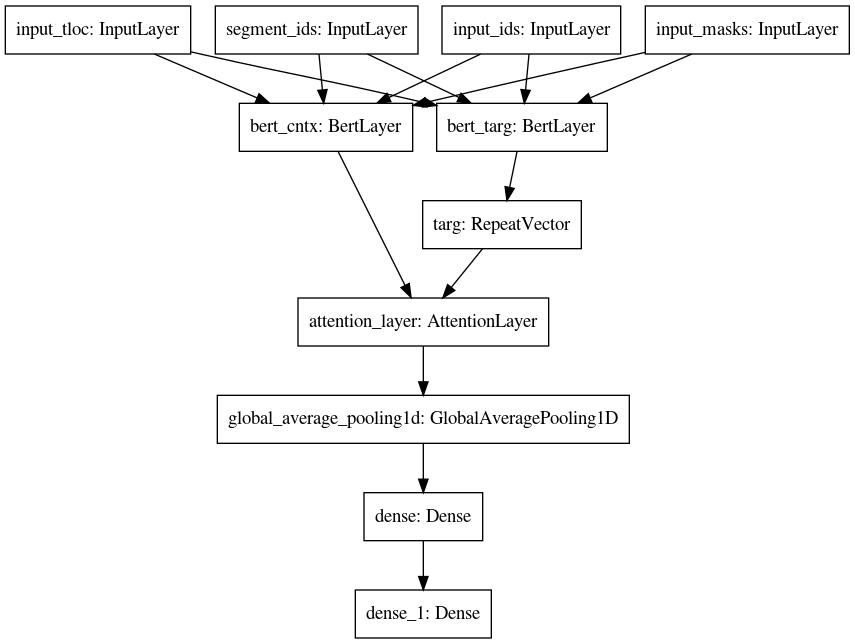

In [15]:
plot_model(model)

# K-fold training and predictions 

In [16]:
# target word location categories
targ_loc_cat = []
for i in range(df_cloze.shape[0]):
    if(df_cloze['targ_loc_end'][i]): 
        targ_loc_cat.append('3_last')
    else:
        if(df_cloze['targ_loc_rel'][i] <= 0.5):
            targ_loc_cat.append('0_less_50')
        elif((df_cloze['targ_loc_rel'][i] > 0.5)&(df_cloze['targ_loc_rel'][i] <= 0.65)):
            targ_loc_cat.append("1_(50_65]")
        elif((df_cloze['targ_loc_rel'][i] > 0.65)):
            targ_loc_cat.append("2_more_65")            

In [17]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [18]:
sent_len_cat = pd.qcut(sent_len, [0, 0.20, 0.40, 0.60, 0.80, 1])
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

In [19]:
_num_iter = 15
_batch_size = 64

# fold settings
gkf1 = GroupKFold(n_splits=K_FOLDS) ## target words
gkf2 = GroupKFold(n_splits=len(Counter(targ_loc_cat))) ## target word locations
gkf3 = GroupKFold(n_splits=len(sent_len_cat.value_counts())) ## sentence length

# Fitted to: BWS 

## fold: target words

In [33]:
X = sentences
y = resp_bws
y_type = 'bws'

### including target word

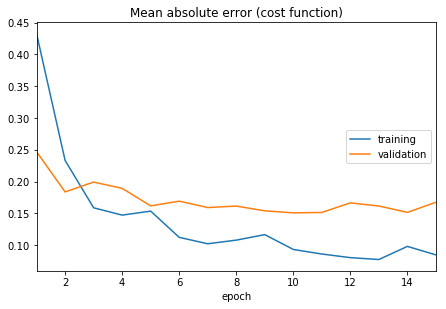

Mean absolute error (cost function):
training   (min:    0.077, max:    0.432, cur:    0.085)
validation (min:    0.151, max:    0.247, cur:    0.167)



In [21]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

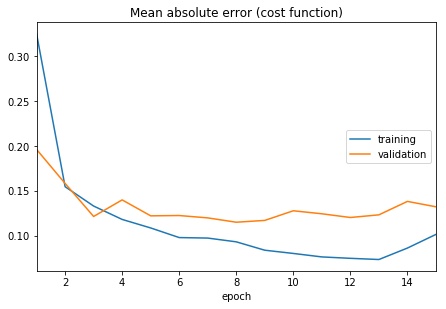

Mean absolute error (cost function):
training   (min:    0.073, max:    0.325, cur:    0.101)
validation (min:    0.115, max:    0.196, cur:    0.132)



In [22]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

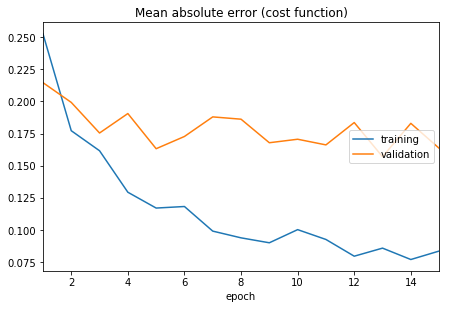

Mean absolute error (cost function):
training   (min:    0.077, max:    0.253, cur:    0.083)
validation (min:    0.157, max:    0.215, cur:    0.164)



In [23]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

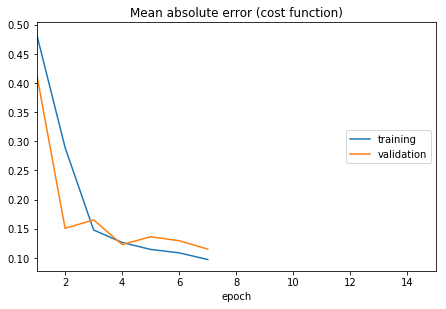

Mean absolute error (cost function):
training   (min:    0.097, max:    0.484, cur:    0.097)
validation (min:    0.115, max:    0.416, cur:    0.115)


In [ ]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: target word locations

### including target word

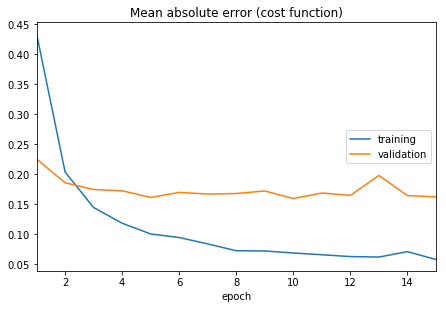

Mean absolute error (cost function):
training   (min:    0.058, max:    0.434, cur:    0.058)
validation (min:    0.159, max:    0.225, cur:    0.162)



In [34]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

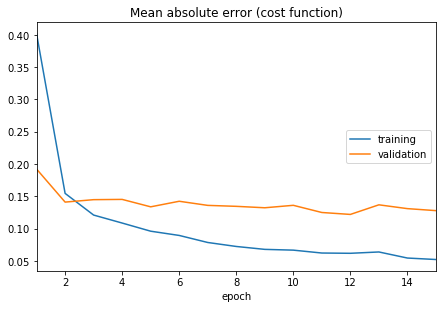

Mean absolute error (cost function):
training   (min:    0.052, max:    0.402, cur:    0.052)
validation (min:    0.122, max:    0.192, cur:    0.128)



In [35]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

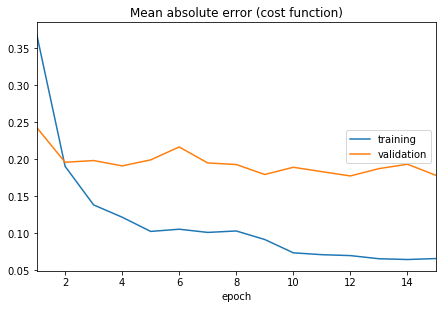

Mean absolute error (cost function):
training   (min:    0.064, max:    0.370, cur:    0.066)
validation (min:    0.177, max:    0.243, cur:    0.178)



In [36]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

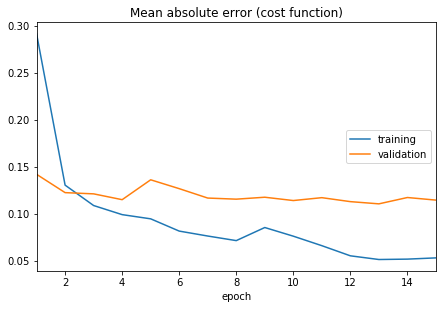

Mean absolute error (cost function):
training   (min:    0.051, max:    0.291, cur:    0.053)
validation (min:    0.110, max:    0.142, cur:    0.114)



In [37]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: sent length

### including target word

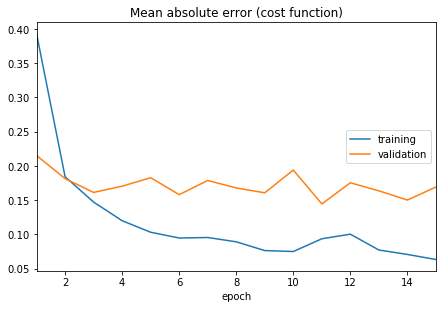

Mean absolute error (cost function):
training   (min:    0.063, max:    0.393, cur:    0.063)
validation (min:    0.144, max:    0.215, cur:    0.169)



In [38]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

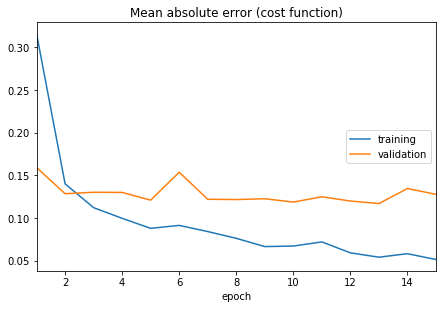

Mean absolute error (cost function):
training   (min:    0.051, max:    0.316, cur:    0.051)
validation (min:    0.117, max:    0.159, cur:    0.128)



In [39]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

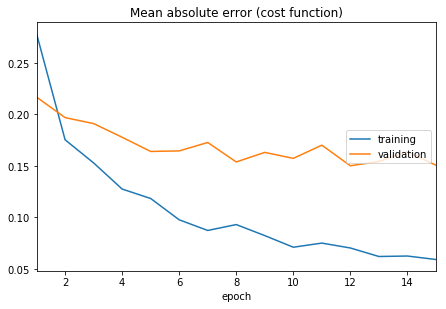

Mean absolute error (cost function):
training   (min:    0.059, max:    0.278, cur:    0.059)
validation (min:    0.150, max:    0.217, cur:    0.151)



In [40]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

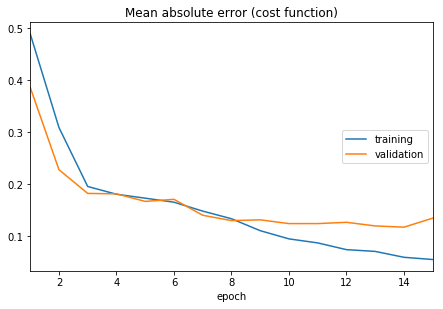

Mean absolute error (cost function):
training   (min:    0.055, max:    0.489, cur:    0.055)
validation (min:    0.117, max:    0.386, cur:    0.134)



In [41]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

# Fitted to: Semantic distance

## fold: target words

In [42]:
X = sentences
y = resp_brt
y_type = 'brt'

### including target word

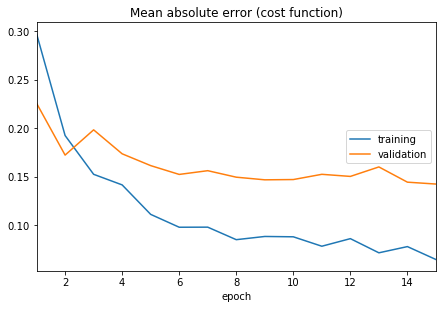

Mean absolute error (cost function):
training   (min:    0.064, max:    0.297, cur:    0.064)
validation (min:    0.142, max:    0.226, cur:    0.142)



In [43]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

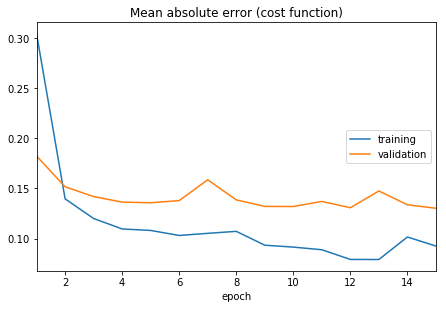

Mean absolute error (cost function):
training   (min:    0.079, max:    0.304, cur:    0.092)
validation (min:    0.130, max:    0.182, cur:    0.130)



In [44]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

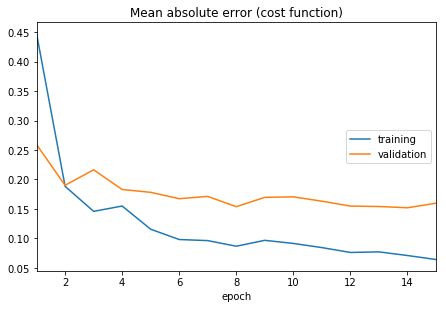

Mean absolute error (cost function):
training   (min:    0.064, max:    0.447, cur:    0.064)
validation (min:    0.152, max:    0.259, cur:    0.160)



In [45]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

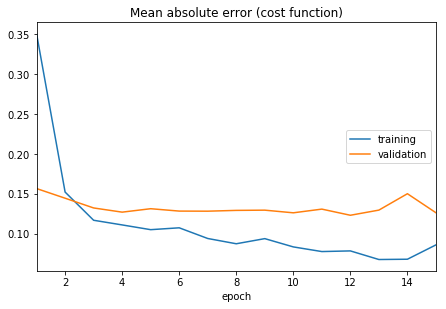

Mean absolute error (cost function):
training   (min:    0.068, max:    0.351, cur:    0.086)
validation (min:    0.123, max:    0.157, cur:    0.126)



In [46]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: target word locations

### including target word

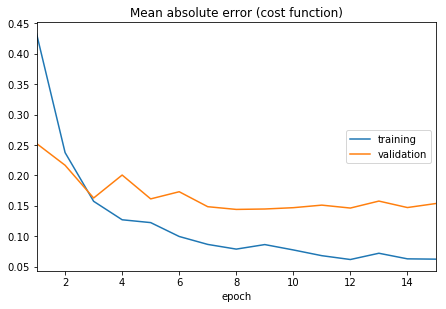

Mean absolute error (cost function):
training   (min:    0.062, max:    0.433, cur:    0.062)
validation (min:    0.144, max:    0.252, cur:    0.154)



In [47]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

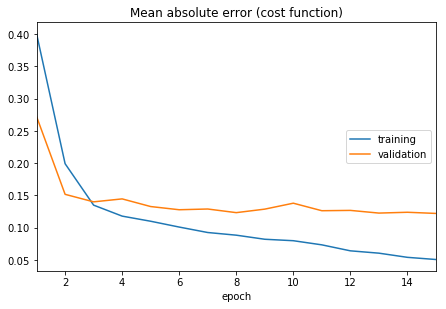

Mean absolute error (cost function):
training   (min:    0.051, max:    0.401, cur:    0.051)
validation (min:    0.122, max:    0.272, cur:    0.122)



In [48]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

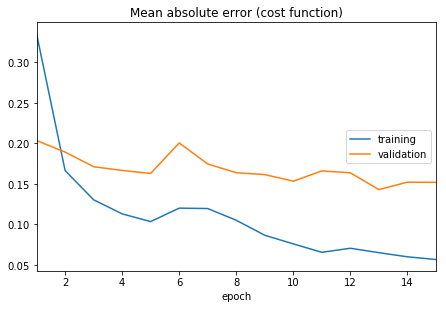

Mean absolute error (cost function):
training   (min:    0.057, max:    0.335, cur:    0.057)
validation (min:    0.143, max:    0.203, cur:    0.152)



In [49]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

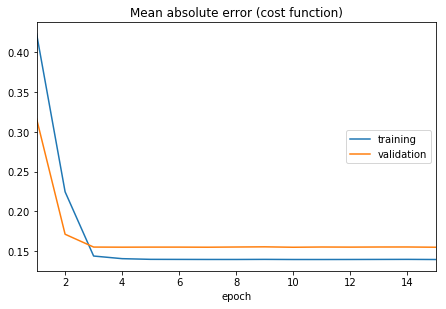

Mean absolute error (cost function):
training   (min:    0.140, max:    0.423, cur:    0.140)
validation (min:    0.155, max:    0.316, cur:    0.155)



In [50]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: sent length

### including target word

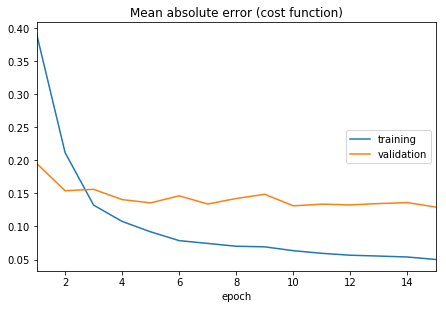

Mean absolute error (cost function):
training   (min:    0.050, max:    0.391, cur:    0.050)
validation (min:    0.129, max:    0.195, cur:    0.129)



In [51]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

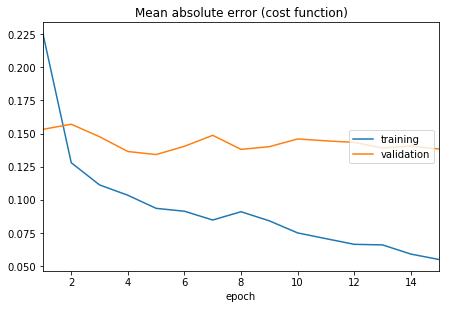

Mean absolute error (cost function):
training   (min:    0.055, max:    0.225, cur:    0.055)
validation (min:    0.134, max:    0.157, cur:    0.138)



In [52]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

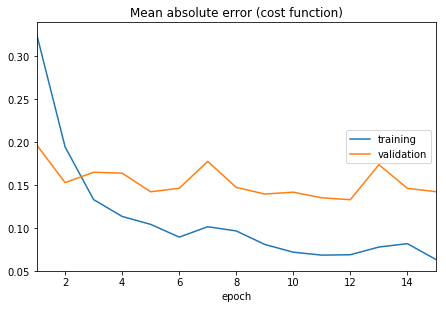

Mean absolute error (cost function):
training   (min:    0.064, max:    0.326, cur:    0.064)
validation (min:    0.133, max:    0.197, cur:    0.142)



In [53]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

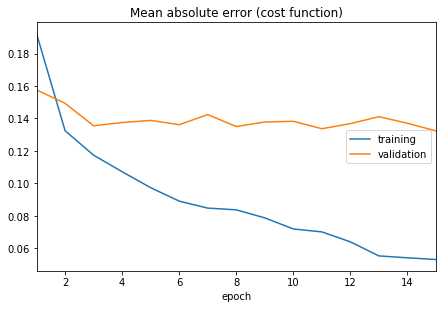

Mean absolute error (cost function):
training   (min:    0.053, max:    0.192, cur:    0.053)
validation (min:    0.132, max:    0.158, cur:    0.132)



In [54]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

# Fitted to: Lexical entropy

## fold: target words

In [55]:
X = sentences
y = resp_lex
y_type = 'lex'

## fold: sent length

### including target word

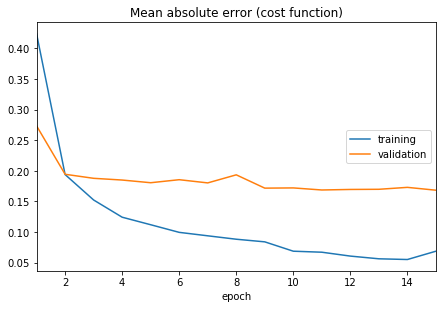

Mean absolute error (cost function):
training   (min:    0.055, max:    0.424, cur:    0.069)
validation (min:    0.168, max:    0.273, cur:    0.168)



In [56]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

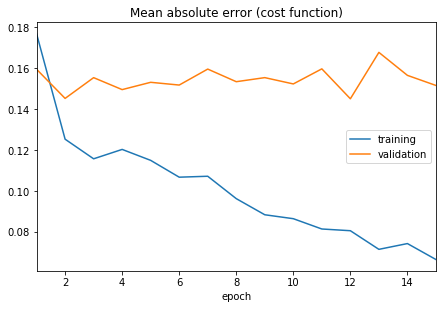

Mean absolute error (cost function):
training   (min:    0.066, max:    0.177, cur:    0.066)
validation (min:    0.145, max:    0.168, cur:    0.152)



In [57]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

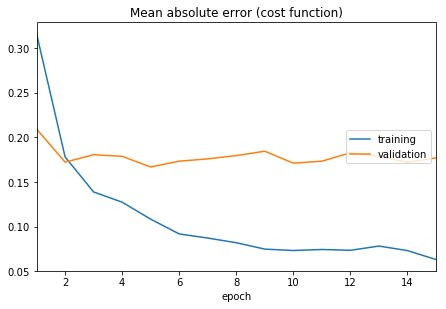

Mean absolute error (cost function):
training   (min:    0.063, max:    0.316, cur:    0.063)
validation (min:    0.167, max:    0.209, cur:    0.177)



In [58]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False, 
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

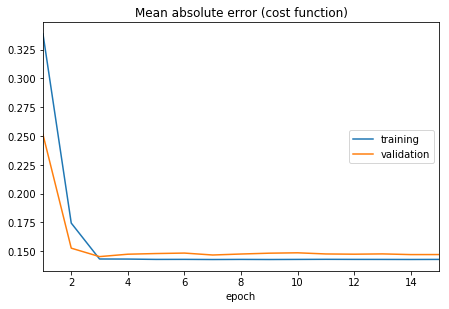

Mean absolute error (cost function):
training   (min:    0.143, max:    0.339, cur:    0.143)
validation (min:    0.145, max:    0.251, cur:    0.147)



In [59]:
gkf_split = gkf3.split(df_cloze['sentence'], groups=sent_len_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvSlen", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvSlen",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### including target word

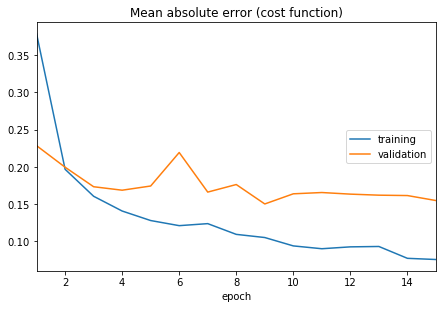

Mean absolute error (cost function):
training   (min:    0.076, max:    0.379, cur:    0.076)
validation (min:    0.150, max:    0.229, cur:    0.155)



In [60]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

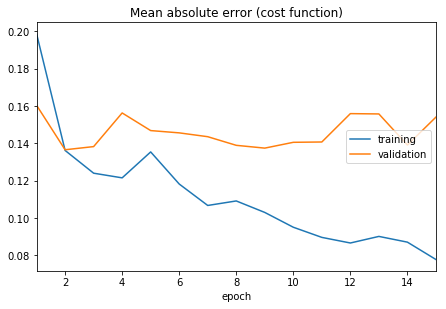

Mean absolute error (cost function):
training   (min:    0.078, max:    0.199, cur:    0.078)
validation (min:    0.137, max:    0.160, cur:    0.154)



In [61]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

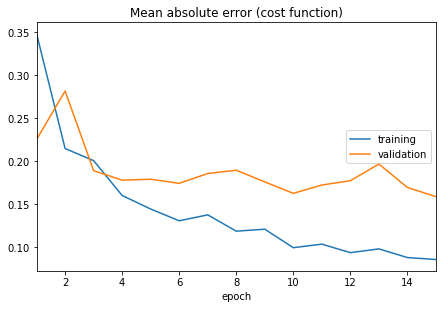

Mean absolute error (cost function):
training   (min:    0.086, max:    0.348, cur:    0.086)
validation (min:    0.159, max:    0.282, cur:    0.159)



In [62]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

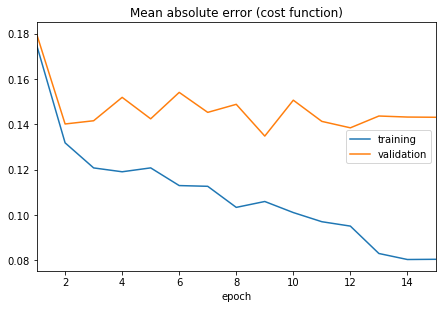

Mean absolute error (cost function):
training   (min:    0.080, max:    0.175, cur:    0.080)
validation (min:    0.135, max:    0.180, cur:    0.143)



In [63]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: target word locations

### including target word

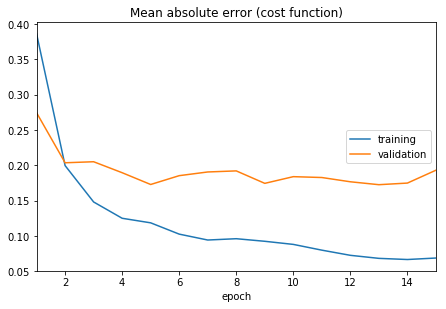

Mean absolute error (cost function):
training   (min:    0.067, max:    0.386, cur:    0.069)
validation (min:    0.173, max:    0.274, cur:    0.193)



In [64]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, False,
                 "./model_weights/model_bert_wttarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

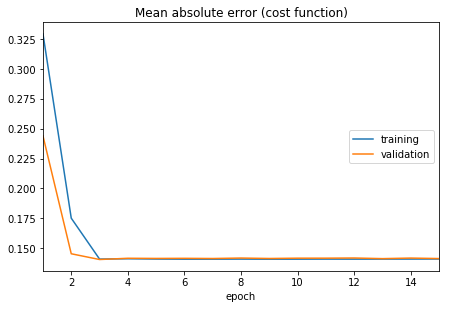

Mean absolute error (cost function):
training   (min:    0.141, max:    0.329, cur:    0.141)
validation (min:    0.141, max:    0.244, cur:    0.141)



In [65]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, True,
                 gkf_split, True,
                 "./model_weights/model_bert_wttarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_wttarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

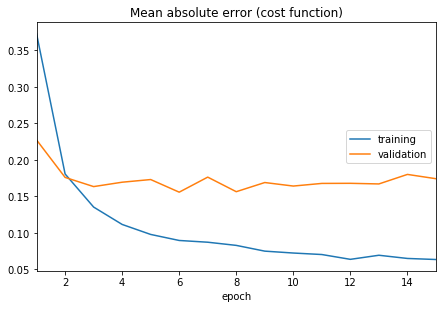

Mean absolute error (cost function):
training   (min:    0.064, max:    0.373, cur:    0.064)
validation (min:    0.156, max:    0.227, cur:    0.174)



In [66]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, False,
                 "./model_weights/model_bert_notarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

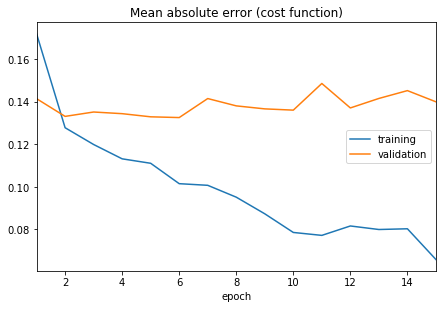

Mean absolute error (cost function):
training   (min:    0.066, max:    0.172, cur:    0.066)
validation (min:    0.133, max:    0.149, cur:    0.140)



In [67]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_bertmod_cv(X, y, False,
                 gkf_split, True,
                 "./model_weights/model_bert_notarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_bert_notarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

# Classification performance 

In [45]:
def roc_cv(cv_true_scores, pred_score_file_loc, score_type, cut, direction, fig, ax, col, ls):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    pred_score_files = sorted(glob.glob(pred_score_file_loc))

    for i in range(len(cv_true_scores)):
        if(direction=="high"):
            fpr, tpr, _ = roc_curve(cv_true_scores[i] > np.quantile(cv_true_scores[i], q=[cut]), np.load(pred_score_files[i]))
        if(direction=="low"):
            fpr, tpr, _ = roc_curve(cv_true_scores[i] < np.quantile(cv_true_scores[i], q=[cut]), 1-np.load(pred_score_files[i]))
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # sns.lineplot(fpr, tpr)
        ax.plot(fpr, tpr, 
                color=col, alpha=0.1,
                # label = 'ROC fold %d (AUC=%0.2f, n=%d)' % (i, roc_auc, fold_set.shape[0])
               )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)    
    ax.plot(mean_fpr, mean_tpr, 
             color=col, alpha=1, linestyle=ls,
             label=r'Mean ROC:'+score_type+' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, 1.96*std_auc),
             lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC__'+str(cut)+"_"+str(direction)+'_5-fold')
    # ax.legend(loc=4, bbox_to_anchor=(0.5, -0.2))
    ax.legend()

In [94]:
sraw_test_cvTwrd = []
sraw_test_cvTloc = []
sraw_test_cvSlen = []

sent_test_cvTwrd = []
sent_test_cvTloc = []
sent_test_cvSlen = []
sent_test_cvTwrd2 = []
sent_test_cvTloc2 = []
sent_test_cvSlen2 = []

resp_bws_cvTwrd = [] 
resp_bws_cvTloc = [] 
resp_bws_cvSlen = [] 
resp_lex_cvTwrd = [] 
resp_lex_cvTloc = [] 
resp_lex_cvSlen = [] 
resp_brt_cvTwrd = [] 
resp_brt_cvTloc = [] 
resp_brt_cvSlen = [] 

for train_idx, test_idx in gkf1.split(df_cloze['sentence'], groups=df_cloze['targ']):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvTwrd.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvTwrd.append(tt_bws)
    resp_brt_cvTwrd.append(tt_brt)
    resp_lex_cvTwrd.append(tt_lex)
    tt_cvTwrd = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvTwrd.append(convert_examples_to_features(tokenizer, tt_cvTwrd, True, MAX_SEQ_LEN))
    sent_test_cvTwrd2.append(convert_examples_to_features(tokenizer, tt_cvTwrd, False, MAX_SEQ_LEN))
    
for train_idx, test_idx in gkf2.split(df_cloze['sentence'], groups=targ_loc_cat):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvTloc.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvTloc.append(tt_bws)
    resp_brt_cvTloc.append(tt_brt)
    resp_lex_cvTloc.append(tt_lex)
    tt_cvTloc = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvTloc.append(convert_examples_to_features(tokenizer, tt_cvTloc, True, MAX_SEQ_LEN))
    sent_test_cvTloc2.append(convert_examples_to_features(tokenizer, tt_cvTloc, False, MAX_SEQ_LEN))
    
for train_idx, test_idx in gkf3.split(df_cloze['sentence'], groups=sent_len_cat):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvSlen.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvSlen.append(tt_bws)
    resp_brt_cvSlen.append(tt_brt)
    resp_lex_cvSlen.append(tt_lex)
    tt_cvSlen = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvSlen.append(convert_examples_to_features(tokenizer, tt_cvSlen, True, MAX_SEQ_LEN))
    sent_test_cvSlen2.append(convert_examples_to_features(tokenizer, tt_cvSlen, False, MAX_SEQ_LEN))

## CV over target words vs. target word location

In [57]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [58]:
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

### fitted to: BWS score
- target location may bias the prediction results in some cases, but not by much
- sentence length may be the problem
- attention layer improve the performance
    - both with/w.o. target word conditions
- NOT including the target word (synonym of the original) improves the performance
- Attention improves the performance
    - attention captures: the relationship between the target (known or unknown) and context

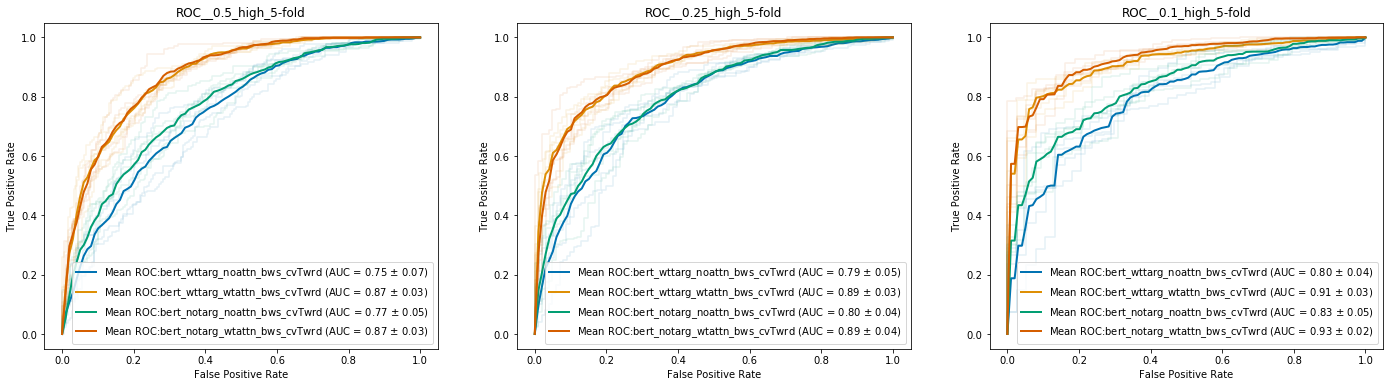

In [62]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3], '-')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3], '-')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3], '-')


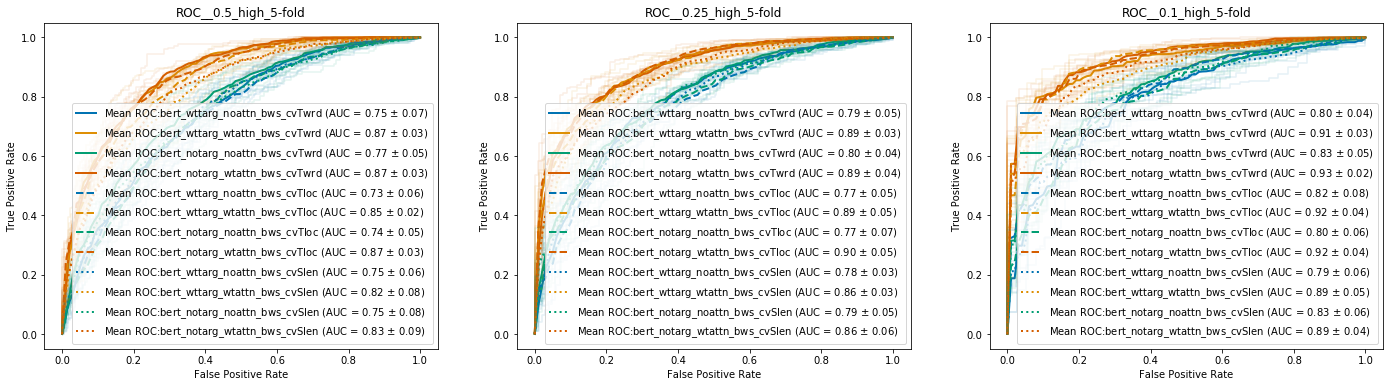

In [25]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.50, "high", fig, axes[0], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.50, "high", fig, axes[0], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.50, "high", fig, axes[0], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.50, "high", fig, axes[0], tt_col[3], ':')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.25, "high", fig, axes[1], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.25, "high", fig, axes[1], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.25, "high", fig, axes[1], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.25, "high", fig, axes[1], tt_col[3], ':')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.10, "high", fig, axes[2], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.10, "high", fig, axes[2], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.10, "high", fig, axes[2], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.10, "high", fig, axes[2], tt_col[3], ':')

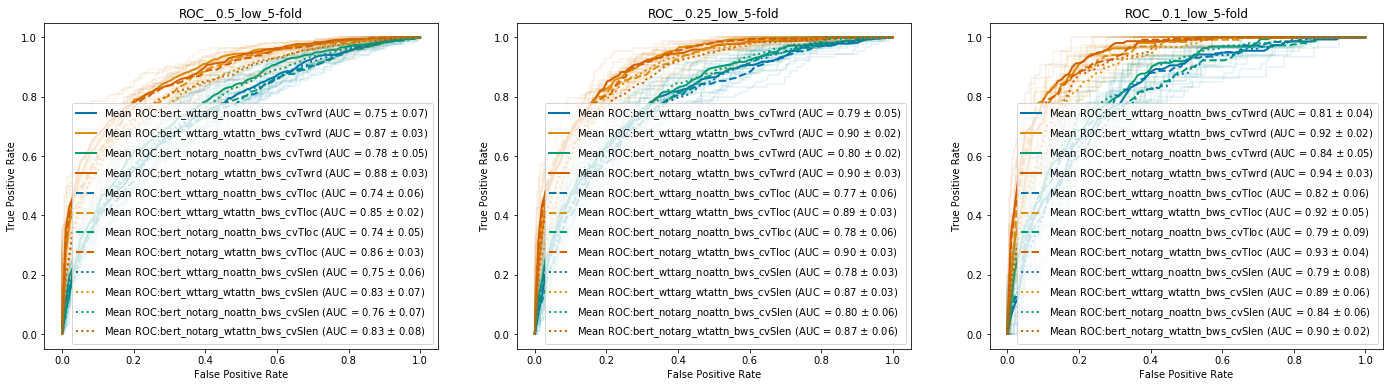

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.50, "low", fig, axes[0], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.50, "low", fig, axes[0], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.50, "low", fig, axes[0], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.50, "low", fig, axes[0], tt_col[3], ':')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.25, "low", fig, axes[1], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.25, "low", fig, axes[1], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.25, "low", fig, axes[1], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.25, "low", fig, axes[1], tt_col[3], ':')

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_bws_cvTwrd*", "bert_wttarg_noattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[0], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTwrd*", "bert_wttarg_wtattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[1], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*", "bert_notarg_noattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[2], '-')
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*", "bert_notarg_wtattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[3], '-')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_noattn_bws_cvTloc*", "bert_wttarg_noattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[0], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_bws_cvTloc*", "bert_wttarg_wtattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[1], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_noattn_bws_cvTloc*", "bert_notarg_noattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[2], '--')
roc_cv(resp_bws_cvTloc, "./model_predict/preds_bert_notarg_wtattn_bws_cvTloc*", "bert_notarg_wtattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[3], '--')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_noattn_bws_cvSlen*", "bert_wttarg_noattn_bws_cvSlen", 0.10, "low", fig, axes[2], tt_col[0], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_bws_cvSlen*", "bert_wttarg_wtattn_bws_cvSlen", 0.10, "low", fig, axes[2], tt_col[1], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_noattn_bws_cvSlen*", "bert_notarg_noattn_bws_cvSlen", 0.10, "low", fig, axes[2], tt_col[2], ':')
roc_cv(resp_bws_cvSlen, "./model_predict/preds_bert_notarg_wtattn_bws_cvSlen*", "bert_notarg_wtattn_bws_cvSlen", 0.10, "low", fig, axes[2], tt_col[3], ':')

### fitted to: Semantic distance
- Semantic distance score vs. BWS
    - cloze response based score vs. ratings on cloze sentences
    - cloze response require additional cognitive process
        - which may introduce additional human bias in reaponse generation/recall of cloze responses
- target location may bias (worse) the prediction results in some cases, but not by much
- NOT including the target word improves the performance IF the model does not include the attention layer
- attention layer increase the performance if the target word is known
    - but it harms the performance if the target word is unknown
    - humans: recall the cloze response based on context + specific semantic ground?

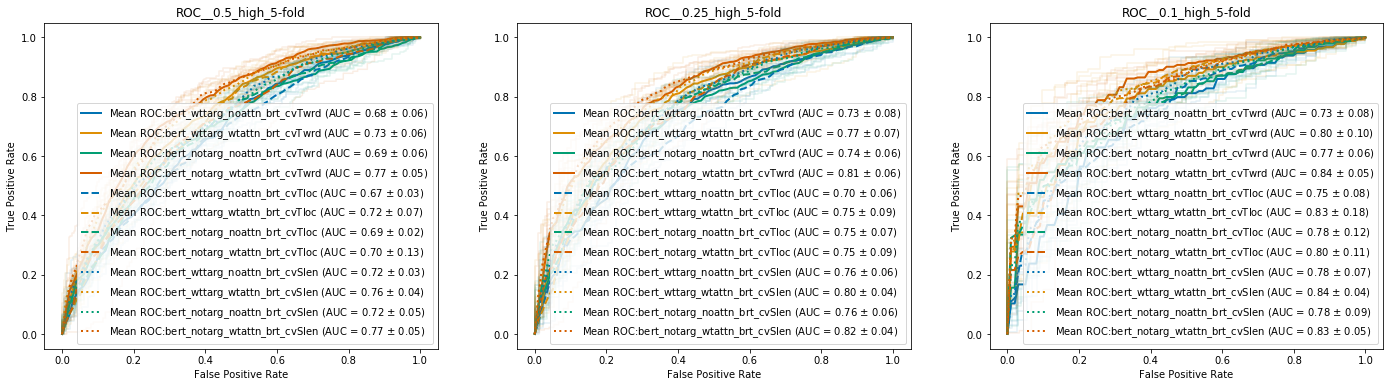

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.50, "high", fig, axes[0], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.50, "high", fig, axes[0], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.50, "high", fig, axes[0], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.50, "high", fig, axes[0], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.50, "high", fig, axes[0], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.50, "high", fig, axes[0], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.50, "high", fig, axes[0], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.50, "high", fig, axes[0], tt_col[3], ':')


roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.25, "high", fig, axes[1], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.25, "high", fig, axes[1], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.25, "high", fig, axes[1], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.25, "high", fig, axes[1], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.25, "high", fig, axes[1], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.25, "high", fig, axes[1], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.25, "high", fig, axes[1], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.25, "high", fig, axes[1], tt_col[3], ':')

roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.10, "high", fig, axes[2], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.10, "high", fig, axes[2], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.10, "high", fig, axes[2], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.10, "high", fig, axes[2], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.10, "high", fig, axes[2], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.10, "high", fig, axes[2], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.10, "high", fig, axes[2], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.10, "high", fig, axes[2], tt_col[3], ':')



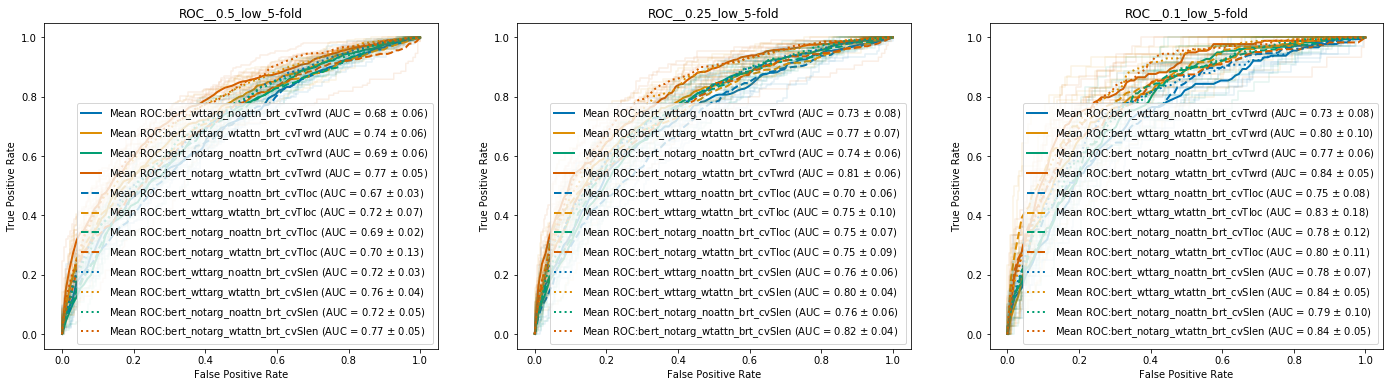

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.50, "low", fig, axes[0], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.50, "low", fig, axes[0], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.50, "low", fig, axes[0], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.50, "low", fig, axes[0], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.50, "low", fig, axes[0], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.50, "low", fig, axes[0], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.50, "low", fig, axes[0], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.50, "low", fig, axes[0], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.50, "low", fig, axes[0], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.50, "low", fig, axes[0], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.50, "low", fig, axes[0], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.50, "low", fig, axes[0], tt_col[3], ':')


roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.25, "low", fig, axes[1], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.25, "low", fig, axes[1], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.25, "low", fig, axes[1], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.25, "low", fig, axes[1], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.25, "low", fig, axes[1], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.25, "low", fig, axes[1], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.25, "low", fig, axes[1], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.25, "low", fig, axes[1], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.25, "low", fig, axes[1], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.25, "low", fig, axes[1], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.25, "low", fig, axes[1], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.25, "low", fig, axes[1], tt_col[3], ':')

roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_brt_cvTwrd*", "bert_wttarg_noattn_brt_cvTwrd", 0.10, "low", fig, axes[2], tt_col[0], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTwrd*", "bert_wttarg_wtattn_brt_cvTwrd", 0.10, "low", fig, axes[2], tt_col[1], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_noattn_brt_cvTwrd*", "bert_notarg_noattn_brt_cvTwrd", 0.10, "low", fig, axes[2], tt_col[2], '-')
roc_cv(resp_brt_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_brt_cvTwrd*", "bert_notarg_wtattn_brt_cvTwrd", 0.10, "low", fig, axes[2], tt_col[3], '-')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_noattn_brt_cvTloc*", "bert_wttarg_noattn_brt_cvTloc", 0.10, "low", fig, axes[2], tt_col[0], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_brt_cvTloc*", "bert_wttarg_wtattn_brt_cvTloc", 0.10, "low", fig, axes[2], tt_col[1], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_noattn_brt_cvTloc*", "bert_notarg_noattn_brt_cvTloc", 0.10, "low", fig, axes[2], tt_col[2], '--')
roc_cv(resp_brt_cvTloc, "./model_predict/preds_bert_notarg_wtattn_brt_cvTloc*", "bert_notarg_wtattn_brt_cvTloc", 0.10, "low", fig, axes[2], tt_col[3], '--')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_noattn_brt_cvSlen*", "bert_wttarg_noattn_brt_cvSlen", 0.10, "low", fig, axes[2], tt_col[0], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_brt_cvSlen*", "bert_wttarg_wtattn_brt_cvSlen", 0.10, "low", fig, axes[2], tt_col[1], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_noattn_brt_cvSlen*", "bert_notarg_noattn_brt_cvSlen", 0.10, "low", fig, axes[2], tt_col[2], ':')
roc_cv(resp_brt_cvSlen, "./model_predict/preds_bert_notarg_wtattn_brt_cvSlen*", "bert_notarg_wtattn_brt_cvSlen", 0.10, "low", fig, axes[2], tt_col[3], ':')



### fitted to: lexical entropy
- target location may bias (improve) the prediction results in some cases, but not by much
- Similar to semantic distance score results: 
    - NOT including the target word improves the performance IF the model does not include the attention layer
    - attention layer increase the performance if the target word is known
        - but nearly no differences if the target word is unknown


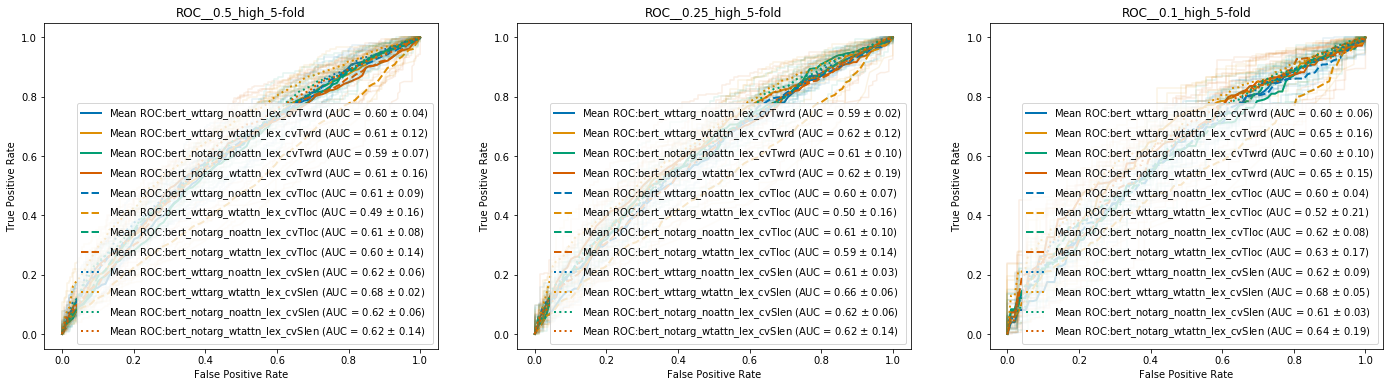

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.50, "high", fig, axes[0], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.50, "high", fig, axes[0], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.50, "high", fig, axes[0], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.50, "high", fig, axes[0], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.50, "high", fig, axes[0], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.50, "high", fig, axes[0], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.50, "high", fig, axes[0], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.50, "high", fig, axes[0], tt_col[3], ':')

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.25, "high", fig, axes[1], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.25, "high", fig, axes[1], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.25, "high", fig, axes[1], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.25, "high", fig, axes[1], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.25, "high", fig, axes[1], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.25, "high", fig, axes[1], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.25, "high", fig, axes[1], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.25, "high", fig, axes[1], tt_col[3], ':')

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.10, "high", fig, axes[2], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.10, "high", fig, axes[2], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.10, "high", fig, axes[2], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.10, "high", fig, axes[2], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.10, "high", fig, axes[2], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.10, "high", fig, axes[2], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.10, "high", fig, axes[2], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.10, "high", fig, axes[2], tt_col[3], ':')


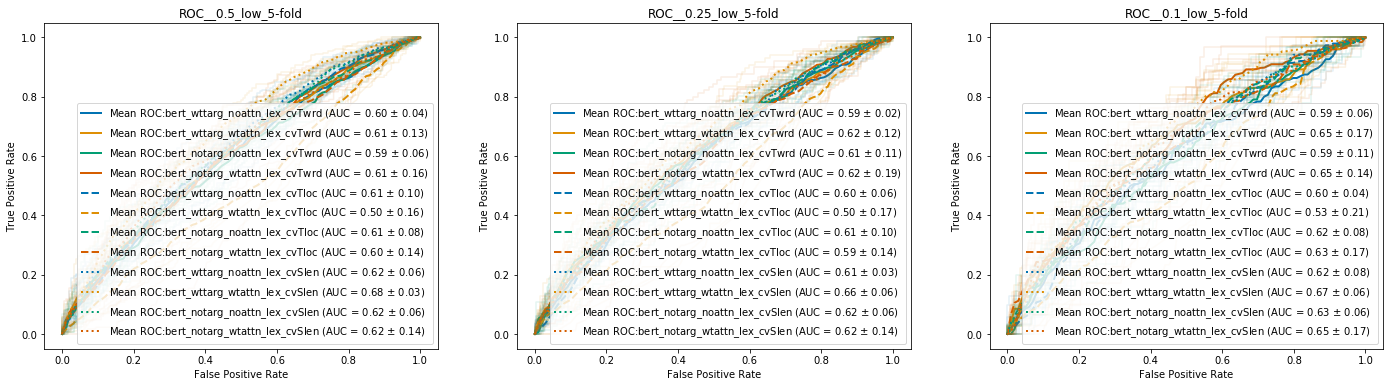

In [30]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.50, "low", fig, axes[0], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.50, "low", fig, axes[0], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.50, "low", fig, axes[0], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.50, "low", fig, axes[0], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.50, "low", fig, axes[0], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.50, "low", fig, axes[0], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.50, "low", fig, axes[0], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.50, "low", fig, axes[0], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.50, "low", fig, axes[0], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.50, "low", fig, axes[0], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.50, "low", fig, axes[0], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.50, "low", fig, axes[0], tt_col[3], ':')

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.25, "low", fig, axes[1], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.25, "low", fig, axes[1], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.25, "low", fig, axes[1], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.25, "low", fig, axes[1], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.25, "low", fig, axes[1], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.25, "low", fig, axes[1], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.25, "low", fig, axes[1], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.25, "low", fig, axes[1], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.25, "low", fig, axes[1], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.25, "low", fig, axes[1], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.25, "low", fig, axes[1], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.25, "low", fig, axes[1], tt_col[3], ':')

roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_noattn_lex_cvTwrd*", "bert_wttarg_noattn_lex_cvTwrd", 0.10, "low", fig, axes[2], tt_col[0], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTwrd*", "bert_wttarg_wtattn_lex_cvTwrd", 0.10, "low", fig, axes[2], tt_col[1], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_noattn_lex_cvTwrd*", "bert_notarg_noattn_lex_cvTwrd", 0.10, "low", fig, axes[2], tt_col[2], '-')
roc_cv(resp_lex_cvTwrd, "./model_predict/preds_bert_notarg_wtattn_lex_cvTwrd*", "bert_notarg_wtattn_lex_cvTwrd", 0.10, "low", fig, axes[2], tt_col[3], '-')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_noattn_lex_cvTloc*", "bert_wttarg_noattn_lex_cvTloc", 0.10, "low", fig, axes[2], tt_col[0], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_wttarg_wtattn_lex_cvTloc*", "bert_wttarg_wtattn_lex_cvTloc", 0.10, "low", fig, axes[2], tt_col[1], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_noattn_lex_cvTloc*", "bert_notarg_noattn_lex_cvTloc", 0.10, "low", fig, axes[2], tt_col[2], '--')
roc_cv(resp_lex_cvTloc, "./model_predict/preds_bert_notarg_wtattn_lex_cvTloc*", "bert_notarg_wtattn_lex_cvTloc", 0.10, "low", fig, axes[2], tt_col[3], '--')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_noattn_lex_cvSlen*", "bert_wttarg_noattn_lex_cvSlen", 0.10, "low", fig, axes[2], tt_col[0], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_wttarg_wtattn_lex_cvSlen*", "bert_wttarg_wtattn_lex_cvSlen", 0.10, "low", fig, axes[2], tt_col[1], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_noattn_lex_cvSlen*", "bert_notarg_noattn_lex_cvSlen", 0.10, "low", fig, axes[2], tt_col[2], ':')
roc_cv(resp_lex_cvSlen, "./model_predict/preds_bert_notarg_wtattn_lex_cvSlen*", "bert_notarg_wtattn_lex_cvSlen", 0.10, "low", fig, axes[2], tt_col[3], ':')


# Prediction results 

In [31]:
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

In [32]:
[len(x) for x in resp_bws_cvSlen]

[428, 351, 343, 331, 330]

## score predictions 

In [63]:
# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
from scipy import stats
def spearmanr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.spearmanr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return {"rho":r, "p-value":p, "ci_low":lo, "ci_high":hi}

In [64]:
K.clear_session()
sess = tf.Session()

tt_mod_s = build_model_bert(MAX_SEQ_LEN, True)
tt_mod_m = build_model_bert(MAX_SEQ_LEN, True)
tt_mod_l = build_model_bert(MAX_SEQ_LEN, True)

initialize_vars(sess)
tt_mod_s.load_weights("model_weights/model_bert_notarg_wtattn_bws_cvTwrd0.h5")
tt_mod_m.load_weights("model_weights/model_bert_notarg_wtattn_bws_cvTwrd2.h5")
tt_mod_l.load_weights("model_weights/model_bert_notarg_wtattn_bws_cvTwrd3.h5")

In [65]:
# tt_sents = []
# for i, sents in enumerate(sent_test_cvSlen):
#     tt_examples = convert_text_to_examples(sents[0], sents[1], resp_bws_cvSlen[i])
#     tt_sents.append(convert_examples_to_features(tokenizer, tt_examples, False, MAX_SEQ_LEN)[:4])

# attn_bws_pred_test = np.reshape(model.predict(sent_test_cvTwrd[0], batch_size=128), -1)
tt_pred_s = np.reshape(tt_mod_s.predict(sent_test_cvSlen[0], batch_size=128), -1)
tt_pred_m = np.reshape(tt_mod_m.predict(sent_test_cvSlen[2], batch_size=128), -1)
tt_pred_l = np.reshape(tt_mod_l.predict(sent_test_cvSlen[3], batch_size=128), -1)

{'rho': 0.765748091958619, 'p-value': 1.097773144773282e-83, 'ci_low': 0.7234729930003729, 'ci_high': 0.8023015894236786}
0.2485357442524849


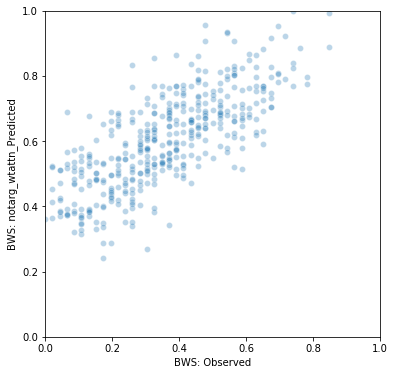

In [70]:
_preds = tt_pred_s
_true = resp_bws_cvSlen[0]
plt.figure(figsize=(6,6))
sns.scatterplot(_true, _preds, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("BWS: Observed")
plt.ylabel("BWS: notarg_wtattn_Predicted")
# print(spearmanr(_true, _preds))
print(spearmanr_ci(_true, _preds))
print(mean_absolute_error(_true, _preds))

{'rho': 0.6454947271128317, 'p-value': 8.181244042058135e-42, 'ci_low': 0.5791897643407726, 'ci_high': 0.7033151073388544}
0.24041718497281142


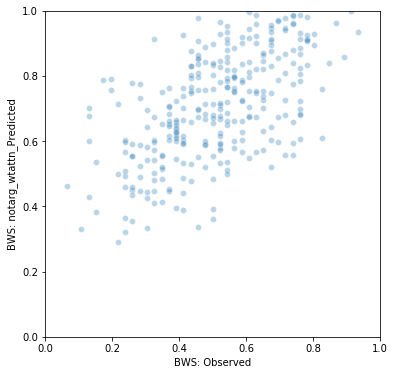

In [71]:
_preds = tt_pred_m
_true = resp_bws_cvSlen[2]
plt.figure(figsize=(6,6))
sns.scatterplot(_true, _preds, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("BWS: Observed")
plt.ylabel("BWS: notarg_wtattn_Predicted")
# print(spearmanr(_true, _preds))
print(spearmanr_ci(_true, _preds))
print(mean_absolute_error(_true, _preds))

{'rho': 0.5559123077498583, 'p-value': 3.0568823742339903e-28, 'ci_low': 0.47667807260385603, 'ci_high': 0.6261868462818475}
0.1452887694077471


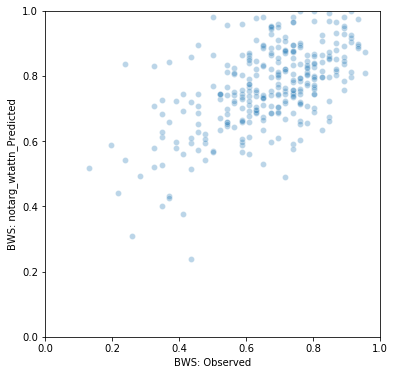

In [72]:
_preds = tt_pred_l
_true = resp_bws_cvSlen[3]
plt.figure(figsize=(6,6))
sns.scatterplot(_true, _preds, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("BWS: Observed")
plt.ylabel("BWS: notarg_wtattn_Predicted")
# print(spearmanr(_true, _preds))
print(spearmanr_ci(_true, _preds))
print(mean_absolute_error(_true, _preds))

In [73]:
K.clear_session()
sess = tf.Session()

model_wttarg_noattn = build_model_bert(MAX_SEQ_LEN, False)
model_wttarg_wtattn = build_model_bert(MAX_SEQ_LEN, True)
model_notarg_noattn = build_model_bert(MAX_SEQ_LEN, False)
model_notarg_wtattn = build_model_bert(MAX_SEQ_LEN, True)
initialize_vars(sess)

model_wttarg_noattn.load_weights("model_weights/model_bert_wttarg_noattn_bws_cvTwrd0.h5")
model_wttarg_wtattn.load_weights("model_weights/model_bert_wttarg_wtattn_bws_cvTwrd0.h5")
model_notarg_noattn.load_weights("model_weights/model_bert_notarg_noattn_bws_cvTwrd0.h5")
model_notarg_wtattn.load_weights("model_weights/model_bert_notarg_wtattn_bws_cvTwrd0.h5")

In [74]:
# attn_bws_pred_test = np.reshape(model.predict(sent_test_cvTwrd[0], batch_size=128), -1)
wttarg_noattn_pred_test = np.reshape(model_wttarg_noattn.predict(sent_test_cvTwrd[0], batch_size=128), -1)
wttarg_wtattn_pred_test = np.reshape(model_wttarg_wtattn.predict(sent_test_cvTwrd[0], batch_size=128), -1)
notarg_noattn_pred_test = np.reshape(model_notarg_noattn.predict(sent_test_cvTwrd2[0], batch_size=128), -1)
notarg_wtattn_pred_test = np.reshape(model_notarg_wtattn.predict(sent_test_cvTwrd2[0], batch_size=128), -1)

### for fold 0

{'rho': 0.7401084778610486, 'p-value': 4.1850172088078e-62, 'ci_low': 0.6887922513174238, 'ci_high': 0.7840450238151102}
0.11853919225407697


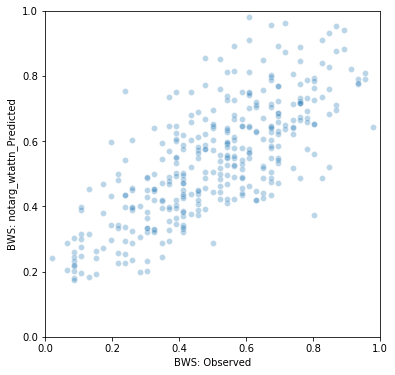

In [78]:
_preds = notarg_wtattn_pred_test
_true = resp_bws_cvTwrd[0]
plt.figure(figsize=(6,6))
sns.scatterplot(_true, _preds, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("BWS: Observed")
plt.ylabel("BWS: notarg_wtattn_Predicted")
# print(spearmanr(_true, _preds))
print(spearmanr_ci(_true, _preds))
print(mean_absolute_error(_true, _preds))

{'rho': 0.5469623245679164, 'p-value': 8.893235887013786e-29, 'ci_low': 0.4691434583101682, 'ci_high': 0.6163525672789842}
0.15044509589387833


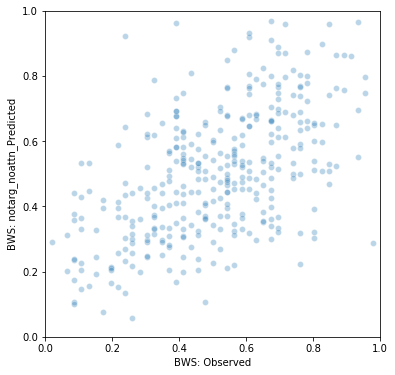

In [80]:
_preds = notarg_noattn_pred_test
_true = resp_bws_cvTwrd[0]
plt.figure(figsize=(6,6))
sns.scatterplot(_true, _preds, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("BWS: Observed")
plt.ylabel("BWS: notarg_noattn_Predicted")
print(spearmanr_ci(_true, _preds))
print(mean_absolute_error(_true, _preds))

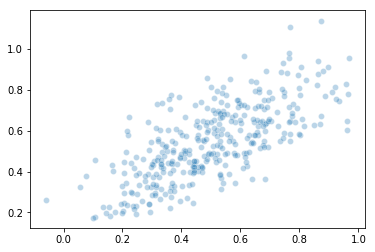

In [81]:
sns.scatterplot(notarg_noattn_pred_test, notarg_wtattn_pred_test, alpha=0.3)

### consolidating predictions from all cv folds

{'rho': 0.7037466802160179, 'p-value': 1.0260251856151073e-266, 'ci_low': 0.6795241680002534, 'ci_high': 0.7264365881854794}
MAE:  0.126 (± 0.182 )


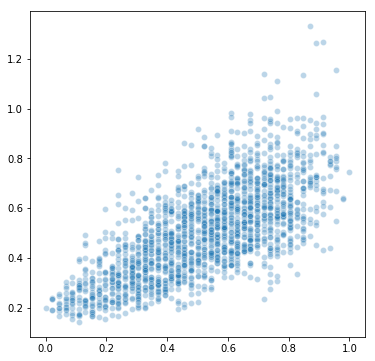

In [82]:
tt_files = sorted(glob.glob("./model_predict/preds_bert_notarg_wtattn_bws_cvTwrd*"))
tt_preds = [np.load(f) for f in tt_files]
tt_preds = [x for xx in tt_preds for x in xx]
tt_obs = sum(resp_bws_cvTwrd, [])

plt.figure(figsize=(6,6))
sns.scatterplot(tt_obs, tt_preds, alpha=0.3)
print(spearmanr_ci(tt_obs, tt_preds))
print("MAE: ", round(np.abs(np.array(tt_obs) - np.array(tt_preds)).mean(), 3),
      "(±", round(np.abs(np.array(tt_obs) - np.array(tt_preds)).std()*1.96, 3), ")")

In [83]:
np.abs(np.array(tt_obs) - np.array(tt_preds)).std()

0.09284817601250246

{'rho': 0.5288153662142648, 'p-value': 4.982778915186956e-129, 'ci_low': 0.49453334430910423, 'ci_high': 0.5614545541405079}
MAE:  0.157 (± 0.239 )


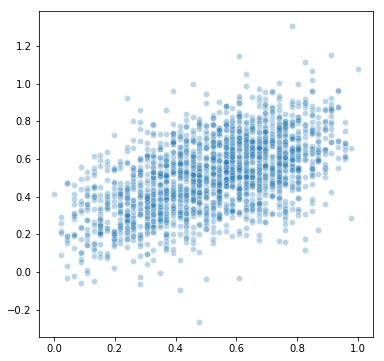

In [84]:
tt_files = sorted(glob.glob("./model_predict/preds_bert_notarg_noattn_bws_cvTwrd*"))
tt_preds = [np.load(f) for f in tt_files]
tt_preds = [x for xx in tt_preds for x in xx]
tt_obs = sum(resp_bws_cvTwrd, [])

plt.figure(figsize=(6,6))
sns.scatterplot(tt_obs, tt_preds, alpha=0.3)
print(spearmanr_ci(tt_obs, tt_preds))
print("MAE: ", round(np.abs(np.array(tt_obs) - np.array(tt_preds)).mean(), 3),
      "(±", round(np.abs(np.array(tt_obs) - np.array(tt_preds)).std()*1.96, 3), ")")

## attention interpretations

In [190]:
model_notarg_sfmxres = Model(model_notarg_wtattn.inputs, model_notarg_wtattn.get_layer('attention_layer').output[1])
model_wttarg_sfmxres = Model(model_wttarg_wtattn.inputs, model_wttarg_wtattn.get_layer('attention_layer').output[1])
# initialize_vars(sess)

In [191]:
hi_test_idx15 = np.prod([(resp_bws_cvTwrd[0] > np.quantile(resp_bws_cvTwrd[0], q=[0.90])),
                         (resp_brt_cvTwrd[0] > np.quantile(resp_brt_cvTwrd[0], q=[0.90]))], axis=0)
lo_test_idx15 = np.prod([(resp_bws_cvTwrd[0] < np.quantile(resp_bws_cvTwrd[0], q=[0.13])),
                         (resp_brt_cvTwrd[0] < np.quantile(resp_brt_cvTwrd[0], q=[0.13]))], axis=0)
hi_test_idx15 = np.where(hi_test_idx15)[0]
lo_test_idx15 = np.where(lo_test_idx15)[0]
(hi_test_idx15, lo_test_idx15)

(array([ 10,  11,  18,  37,  49, 172, 186, 217, 234, 295]),
 array([  5,  38,  39,  82, 155, 216, 222, 299, 301, 348, 349]))

In [192]:
tt_notarg_attn = model_notarg_sfmxres.predict([sent for sent in sent_test_cvTwrd2[0]])[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict([sent for sent in sent_test_cvTwrd[0]])[:,0,:]

#### high informative sentences

In [193]:
def min_max_sc(_x): 
    x = np.array(_x)
    return (x-x.min())/(x.max()-x.min())

In [194]:
np.not_equal(sent_test_cvTwrd2[0][0], 0)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [195]:
def draw_attn_tok(_tokenizer, attn_weights, sent_input, true_score, pred_score, _label, ax, _align_edge=None):
    attn_score = attn_weights * np.not_equal(sent_input[0], 0) #1 #sent_input[1]
    attn_score = min_max_sc(attn_score)
    
    if(_align_edge is None):
        ax.bar(x=_tokenizer.convert_ids_to_tokens(sent_input[0]), height=attn_score, width=-0.25, label=_label)
    else:
        ax.bar(x=_tokenizer.convert_ids_to_tokens(sent_input[0]), height=attn_score, width=0.15, label=_label, align='edge')
    ax.set_title(_label + " BWS score: "+str(round(true_score, 3))+
                 ", pred score: "+str(round(pred_score, 3)))    
    ax.tick_params(axis='x', rotation=90)
    ax.legend()

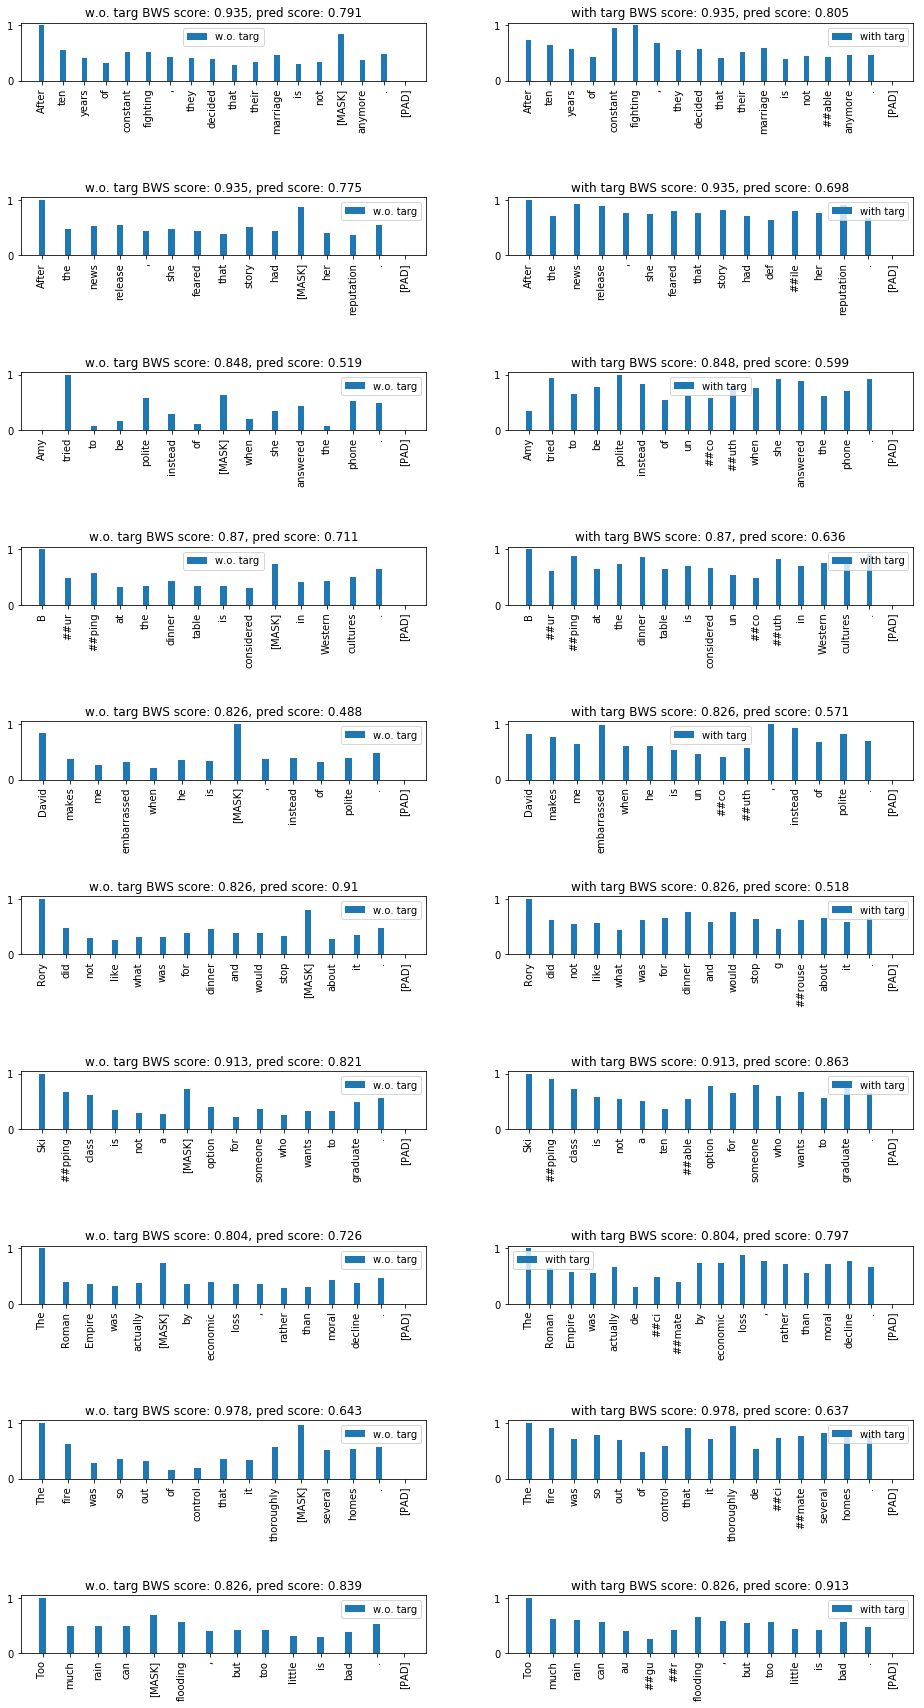

In [196]:
fig, axes = plt.subplots(len(hi_test_idx15), 2, figsize=(16, len(hi_test_idx15)*3))
fig.subplots_adjust(hspace=2)

for i,j in enumerate(hi_test_idx15):
    draw_attn_tok(tokenizer, tt_notarg_attn[j], [sent[j] for sent in sent_test_cvTwrd2[0]], resp_bws_cvTwrd[0][j], notarg_wtattn_pred_test[j], "w.o. targ", axes[i][0])
    draw_attn_tok(tokenizer, tt_wttarg_attn[j], [sent[j] for sent in sent_test_cvTwrd[0]], resp_bws_cvTwrd[0][j], wttarg_wtattn_pred_test[j], "with targ", axes[i][1])

#### low informative sentences

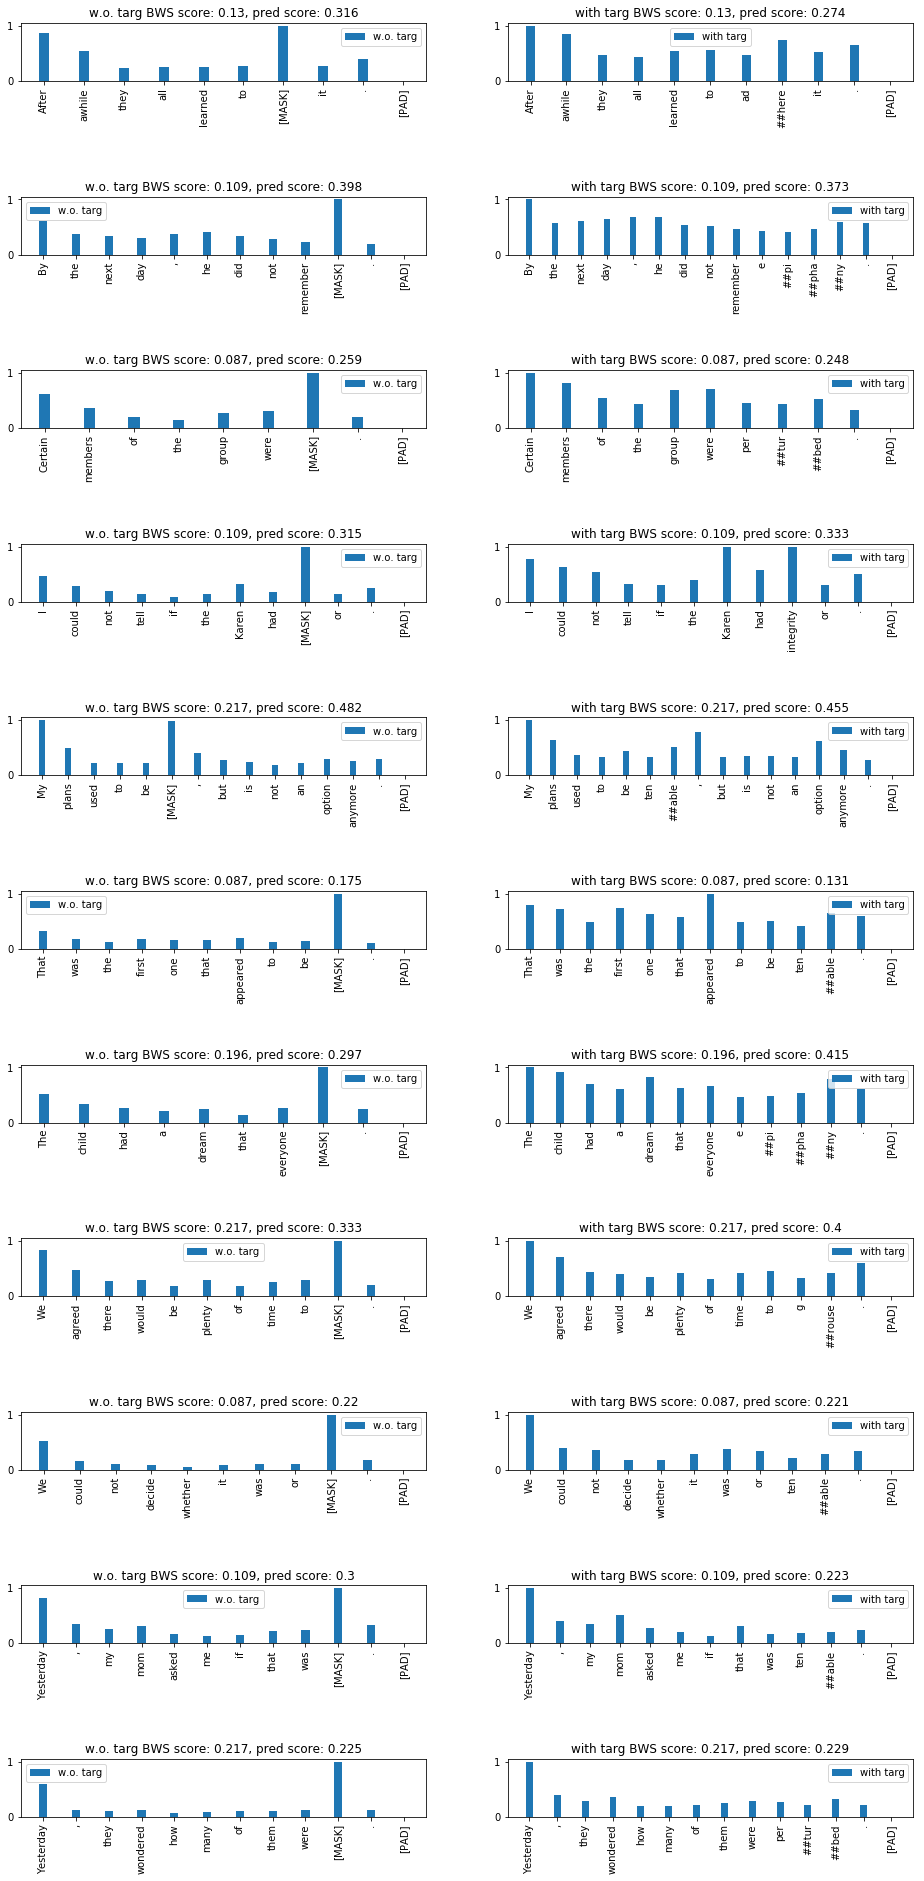

In [197]:
fig, axes = plt.subplots(len(lo_test_idx15), 2, figsize=(16, len(lo_test_idx15)*3))
fig.subplots_adjust(hspace=2)

for i,j in enumerate(lo_test_idx15):
    draw_attn_tok(tokenizer, tt_notarg_attn[j], [sent[j] for sent in sent_test_cvTwrd2[0]], resp_bws_cvTwrd[0][j], notarg_wtattn_pred_test[j], "w.o. targ", axes[i][0])
    draw_attn_tok(tokenizer, tt_wttarg_attn[j], [sent[j] for sent in sent_test_cvTwrd[0]], resp_bws_cvTwrd[0][j], wttarg_wtattn_pred_test[j], "with targ", axes[i][1])

# Anecdotal examples - High informative sentences
- context cue categories (based on DSCoVAR_TR2016-005_AnnotatingContextCues.docx)
    - Synonymous
    - Antonymous
    - Causal

In [198]:
df_ex_hinfo = pd.read_csv("./dataset/hiinfo_examples.csv")
df_ex_hinfo

Cue                Cue Words  \
0   Synonym   X, that is, Y...        
1   Synonym   X , or Y....            
2   Synonym   X, i.e., Y....          
3   Synonym  X, in other words, Y     
4   Synonym  X, meaning (that) Y      
5   Antonym  X, unlike, Y...          
6   Antonym  X , instead of Y....     
7   Antonym  not X, but Y....         
8   Antonym  X, rather than Y...      
9   Antonym  X, as opposed to Y...    
10  Causal   X, because (of) Y        
11  Causal    X, after (or when) Y    
12  Causal   X (in order) to Y        
13  Causal   X by (means of) Y        
14  Causal   X for Y                  
15  Causal   X due to Y               
16  Causal   X so Y                   
17  Causal   If X (then) Y            
18  Causal   X since Y                
19  Causal   X thanks to Y            
20  Causal   X as a result of Y       
21  Causal   X leads to Y             
22  Causal   X causes Y               

                                                               Example context  \
0   The world is full of ______, that is, skeptics.                              
1   The world is full of ______ or skeptics.                                     
2   The world is full of ______, i.e., skeptics.                                 
3   The world is full of ______ , in other words, skeptics.                      
4   John is a ______ which means that he is skeptical.                           
5   These are ______, unlike the yummy ones we had yesterday.                    
6   These are ______ instead of yummy.                                           
7   These are not ______, but yummy.                                             
8   These are ______, rather than yummy.                                         
9   These are ______, as opposed to yummy.                                       
10  The child was ______ because she lied to her parents.                        
11  The child was ______ after [when] she lied to her parents.                   
12  The child lied to avoid being ______ by her parents.                         
13  By lying to her parents, the child was guaranteed to be ______.              
14  The child was ______ for lying to her parents.                               
15  The child was ______ due to her lying to her parents.                        
16  The child's parents ______ her so she would stop lying.                      
17  She will be ______ if she doesn't stop lying.                                
18  Since she lied, the child was ______ by her parents.                         
19  She was ______ by her parents, thanks to her little brother (the snitch!).   
20  She was ______ as a results of her little brother snitching.                 
21  Lying to one's parents can lead to them ______ you.                          
22  When you lie, it may cause your parents to ______ you.                       

           targ      syn1  
0   zetetics     cynic     
1   zetetics     cynic     
2   zetetics     cynic     
3   zetetics     cynic     
4   zetetics     cynic     
5   sapid        tasty     
6   sapid        tasty     
7   sapid        tasty     
8   sapid        tasty     
9   sapid        tasty     
10  castigated   berate    
11  castigated   berate    
12  castigated   berate    
13  castigated   berate    
14  castigated   berate    
15  castigated   berate    
16  castigated   berate    
17  castigated   berate    
18  castigated   berate    
19  castigated   berate    
20  castigated   berate    
21  castigating  berating  
22  castigate    berate

In [199]:
sentences_high = proc_sentences(df_ex_hinfo, "Example context", "syn1")
sentences_high2 = proc_sentences(df_ex_hinfo, "Example context", None)

In [200]:
sentences_high_syn = [xx[df_ex_hinfo["Cue "]=="Synonym"] for xx in sentences_high]
sentences_high_ant = [xx[df_ex_hinfo["Cue "]=="Antonym"] for xx in sentences_high]
sentences_high_cau = [xx[df_ex_hinfo["Cue "]=="Causal"]  for xx in sentences_high]
sentences_high2_syn = [xx[df_ex_hinfo["Cue "]=="Synonym"] for xx in sentences_high2]
sentences_high2_ant = [xx[df_ex_hinfo["Cue "]=="Antonym"] for xx in sentences_high2]
sentences_high2_cau = [xx[df_ex_hinfo["Cue "]=="Causal"]  for xx in sentences_high2]

## synonym
- w.o. target word: more emphasize on 'skeptical', which is a synonym cue

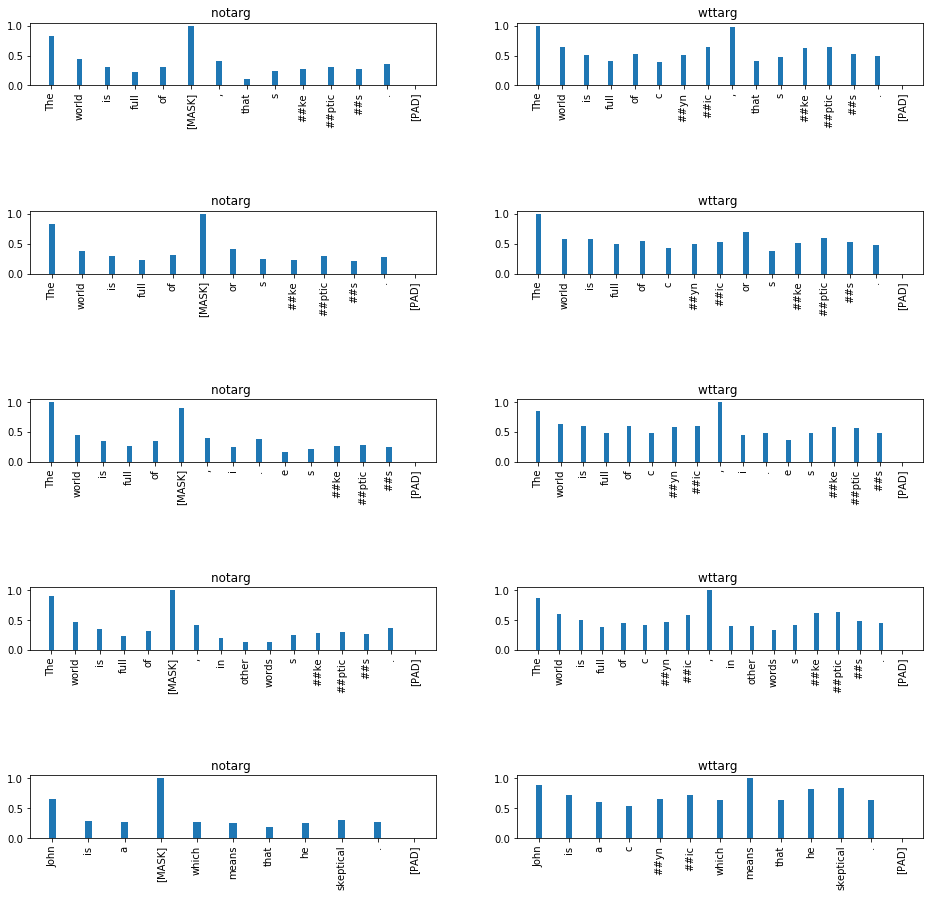

In [216]:
tt_sent = sentences_high_syn
tt_test  = convert_text_to_examples(tt_sent[0], tt_sent[1], np.zeros(len(tt_sent[0])))
sent_test  = convert_examples_to_features(tokenizer, tt_test, True, MAX_SEQ_LEN)
sent_test2 = convert_examples_to_features(tokenizer, tt_test, False, MAX_SEQ_LEN)
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test2)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = min_max_sc(tt_notarg_attn[i]*np.not_equal(sent_test2[0][i], 0))#*(sent_test2[2][i]+sent_test2[3][i]))
    tt2 = min_max_sc(tt_wttarg_attn[i]*np.not_equal(sent_test[0][i], 0))#*(sent_test[2][i]+sent_test[3][i]))
    
    axes[i][0].bar(x=tokenizer.convert_ids_to_tokens(sent_test2[0][i]), height=tt1, width=0.2)
    axes[i][1].bar(x=tokenizer.convert_ids_to_tokens(sent_test[0][i]), height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)
#     axes[i][0].set_xticks(range(sent_test2[0][i]+1))
#     axes[i][1].set_xticks(range(sent_test[0][i]+1))
#     axes[i][0].set_xticklabels(sent_test2[1][i])
#     axes[i][1].set_xticklabels(sent_test[1][i])

## antonym
- w.o. target word: more emphasize on yummy? (sentences are short...)

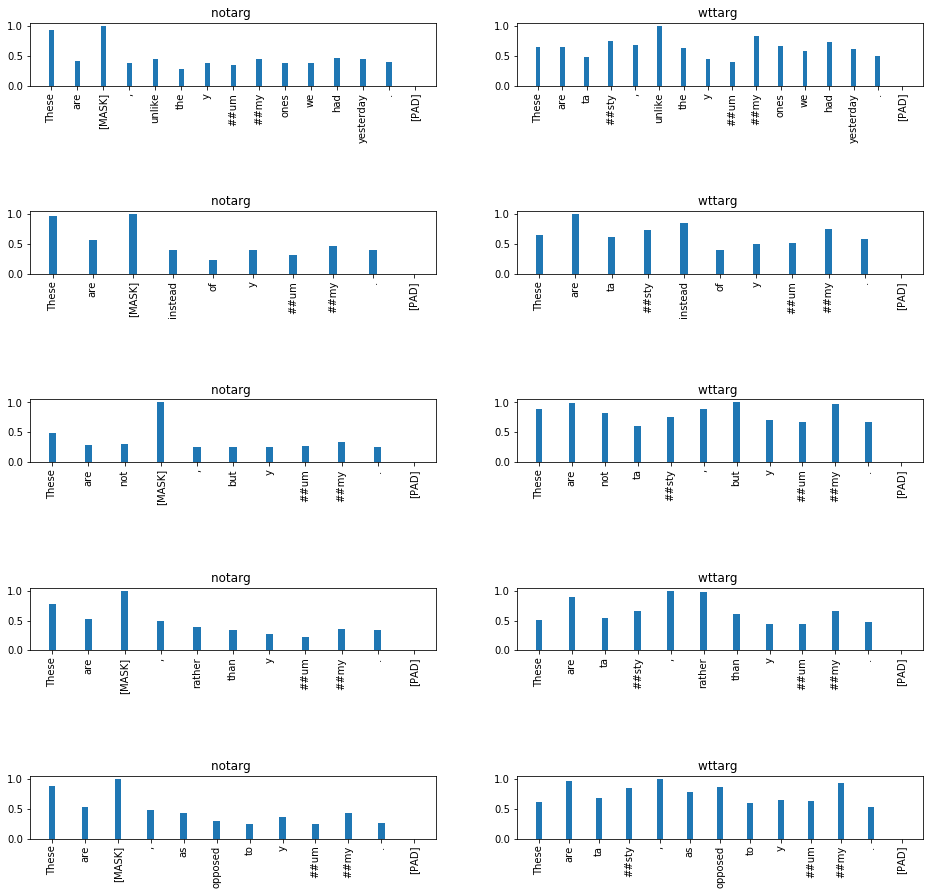

In [217]:
tt_sent = sentences_high_ant
tt_test  = convert_text_to_examples(tt_sent[0], tt_sent[1], np.zeros(len(tt_sent[0])))
sent_test  = convert_examples_to_features(tokenizer, tt_test, True, MAX_SEQ_LEN)
sent_test2 = convert_examples_to_features(tokenizer, tt_test, False, MAX_SEQ_LEN)
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test2)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = min_max_sc(tt_notarg_attn[i]*np.not_equal(sent_test2[0][i], 0))#*(sent_test2[2][i]+sent_test2[3][i]))
    tt2 = min_max_sc(tt_wttarg_attn[i]*np.not_equal(sent_test[0][i], 0))#*(sent_test[2][i]+sent_test[3][i]))
    
    axes[i][0].bar(x=tokenizer.convert_ids_to_tokens(sent_test2[0][i]), height=tt1, width=0.2)
    axes[i][1].bar(x=tokenizer.convert_ids_to_tokens(sent_test[0][i]), height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)
    

## causal
- w.o. target word: more emphasize on lying, which is the cause

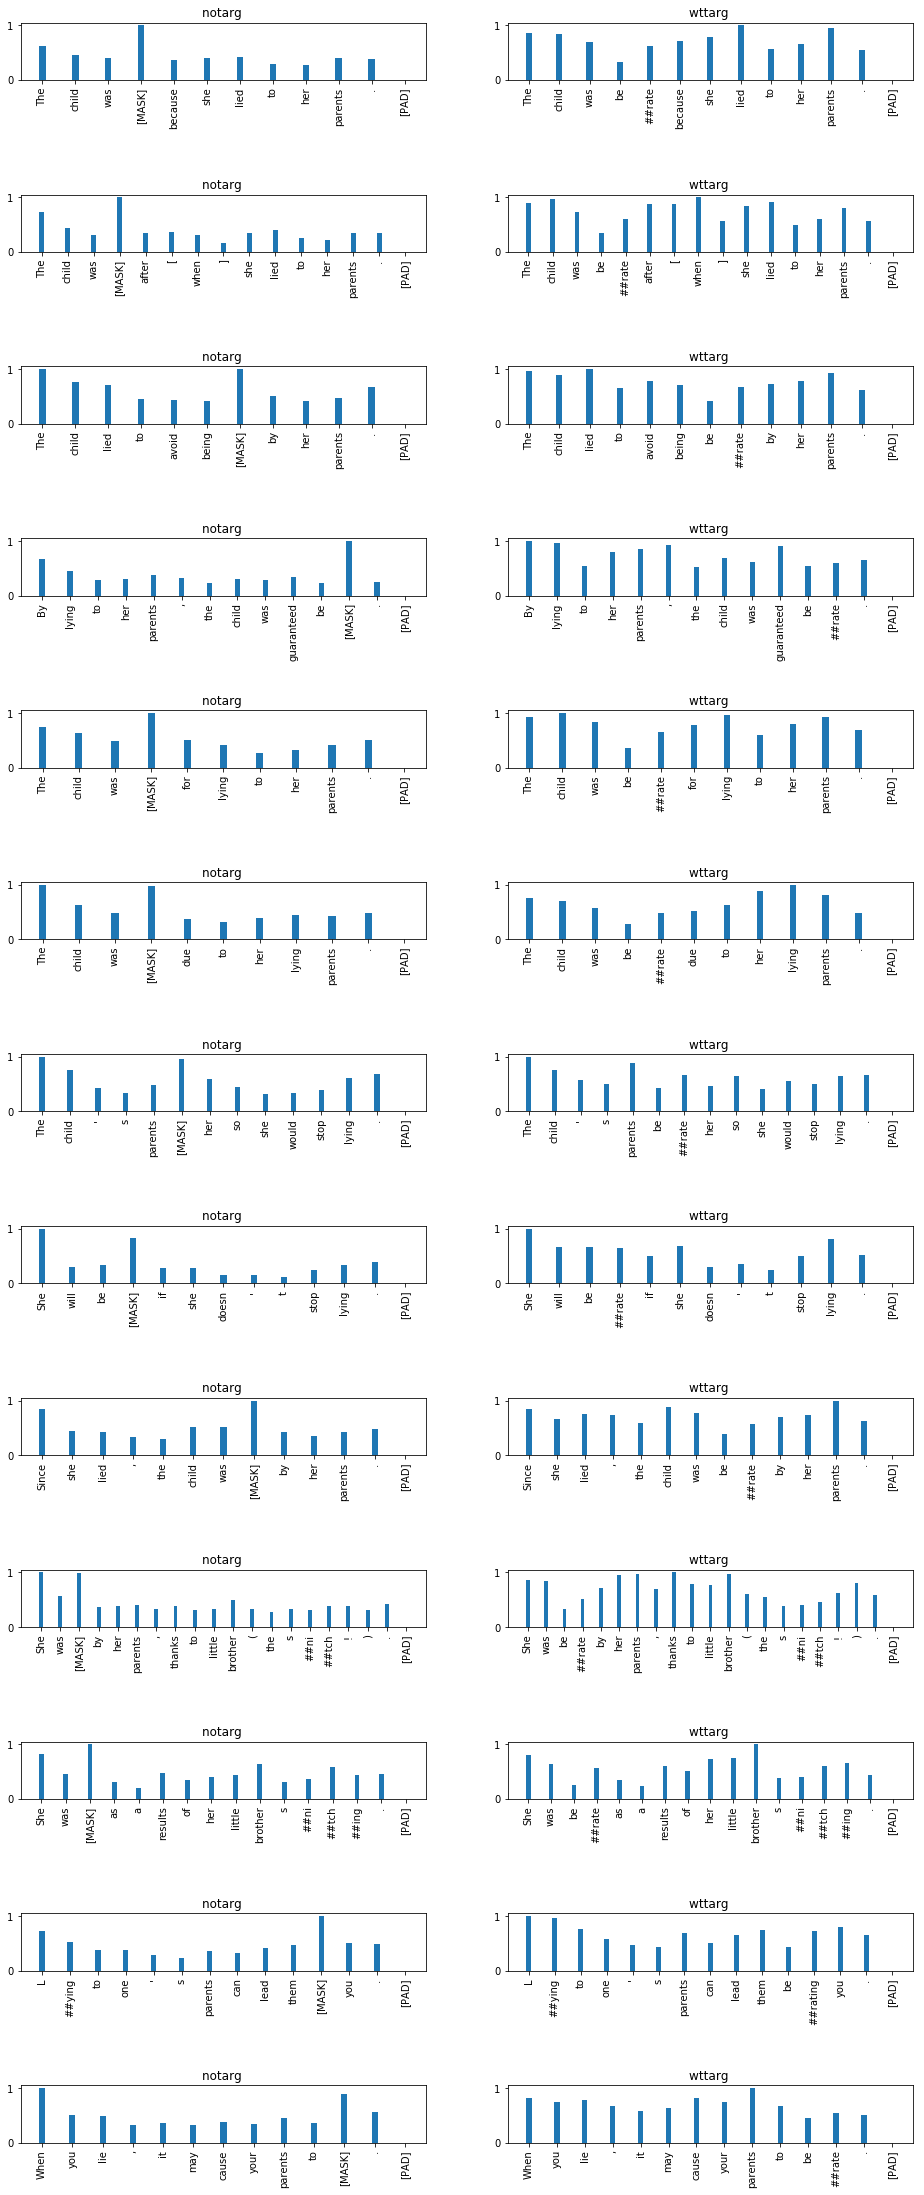

In [218]:
tt_sent = sentences_high_cau
tt_test  = convert_text_to_examples(tt_sent[0], tt_sent[1], np.zeros(len(tt_sent[0])))
sent_test  = convert_examples_to_features(tokenizer, tt_test, True, MAX_SEQ_LEN)
sent_test2 = convert_examples_to_features(tokenizer, tt_test, False, MAX_SEQ_LEN)
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test2)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = min_max_sc(tt_notarg_attn[i]*np.not_equal(sent_test2[0][i], 0))#*(sent_test2[2][i]+sent_test2[3][i]))
    tt2 = min_max_sc(tt_wttarg_attn[i]*np.not_equal(sent_test[0][i], 0))#*(sent_test[2][i]+sent_test[3][i]))
    
    axes[i][0].bar(x=tokenizer.convert_ids_to_tokens(sent_test2[0][i]), height=tt1, width=0.2)
    axes[i][1].bar(x=tokenizer.convert_ids_to_tokens(sent_test[0][i]), height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)    

## homonym

In [181]:
df_ex_homopoly = pd.read_csv("./dataset/polynym_homonym.csv")
df_ex_homopoly

type               sense  \
0  homonymy  NaN                  
1  homonymy  NaN                  
2  homonymy  NaN                  
3  homonymy  NaN                  
4  polysemy  object               
5  polysemy  company              
6  polysemy  moral judgement      
7  polysemy  judgement of skill   

                                                                   sentence  \
0  Sarah climbed ______ the ladder.                                           
1  Sarah bought a ______ blanket.                                             
2  My dog would always ______ at mailmen.                                     
3  The tree's ______ was a rusty brown.                                       
4  The ______ got wet in the rain.                                            
5  The ______ fired some of its editing staff.                                
6  John was a ______ man. He donated a lot of money to charity.               
7  Bill was a ______ painter. His drawings always were exciting to look at.   

        targ  
0  down       
1  down       
2  bark       
3  bark       
4  newspaper  
5  newspaper  
6  good       
7  good

In [182]:
sentences_hp = proc_sentences(df_ex_homopoly, "sentence", "targ")
sentences_hp2 = proc_sentences(df_ex_homopoly, "sentence", None)
sentences_hp2

[array(['[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
        '[MASK]', '[MASK]'], dtype='<U6'),
 array(['Sarah climbed [MASK] the ladder.',
        'Sarah bought a [MASK] blanket.',
        'My dog would always [MASK] at mailmen.',
        "The tree's [MASK] was a rusty brown.",
        'The [MASK] got wet in the rain.',
        'The [MASK] fired some of its editing staff.',
        'John was a [MASK] man. He donated a lot of money to charity.',
        'Bill was a [MASK] painter. His drawings always were exciting to look at.'],
       dtype='<U72')]

In [183]:
sentences_homo = [xx[df_ex_homopoly["type"]=="homonymy"] for xx in sentences_hp]
sentences_poly = [xx[df_ex_homopoly["type"]=="polysemy"] for xx in sentences_hp]
sentences_homo2 = [xx[df_ex_homopoly["type"]=="homonymy"] for xx in sentences_hp2]
sentences_poly2 = [xx[df_ex_homopoly["type"]=="polysemy"] for xx in sentences_hp2]

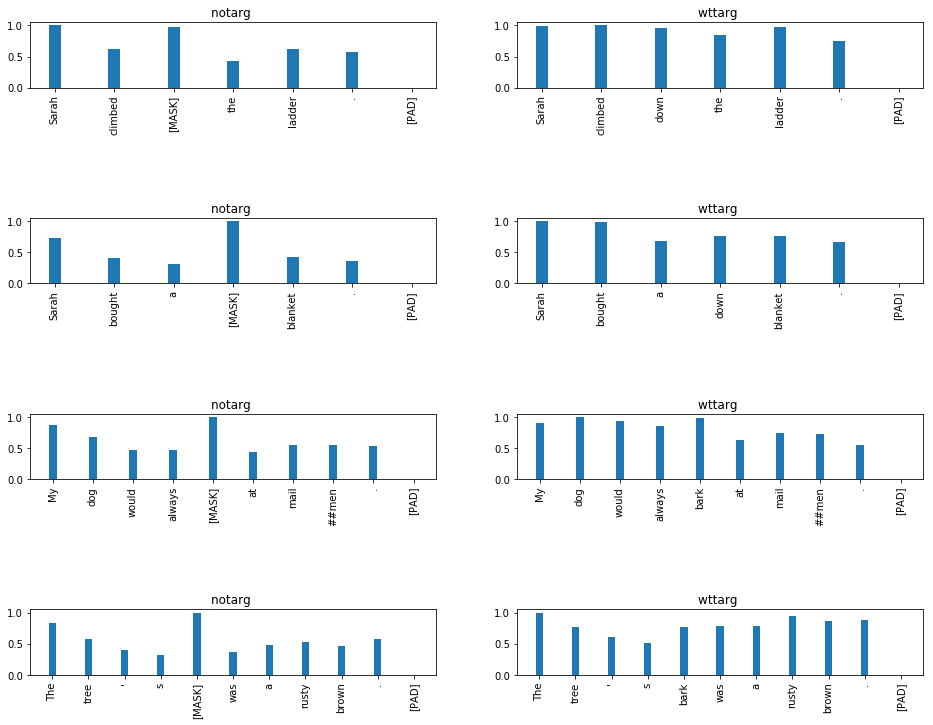

In [219]:
tt_sent = sentences_homo
tt_test  = convert_text_to_examples(tt_sent[0], tt_sent[1], np.zeros(len(tt_sent[0])))
sent_test  = convert_examples_to_features(tokenizer, tt_test, True, MAX_SEQ_LEN)
sent_test2 = convert_examples_to_features(tokenizer, tt_test, False, MAX_SEQ_LEN)
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test2)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = min_max_sc(tt_notarg_attn[i]*np.not_equal(sent_test2[0][i], 0))#*(sent_test2[2][i]+sent_test2[3][i]))
    tt2 = min_max_sc(tt_wttarg_attn[i]*np.not_equal(sent_test[0][i], 0))#*(sent_test[2][i]+sent_test[3][i]))
    
    axes[i][0].bar(x=tokenizer.convert_ids_to_tokens(sent_test2[0][i]), height=tt1, width=0.2)
    axes[i][1].bar(x=tokenizer.convert_ids_to_tokens(sent_test[0][i]), height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)
    

## polysenym

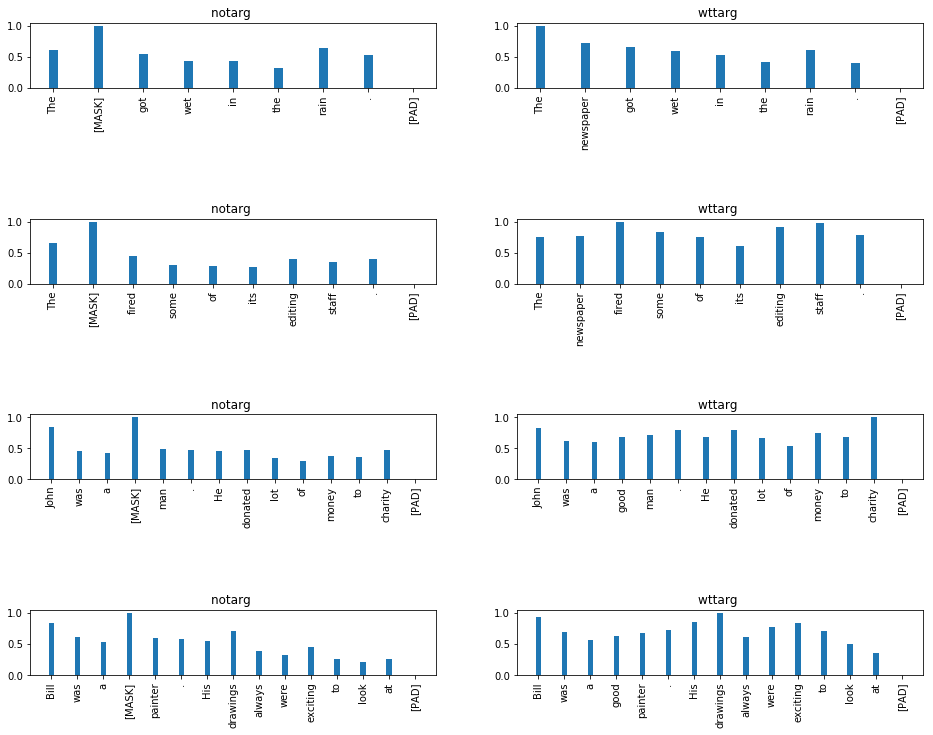

In [220]:
tt_sent = sentences_poly
tt_test  = convert_text_to_examples(tt_sent[0], tt_sent[1], np.zeros(len(tt_sent[0])))
sent_test  = convert_examples_to_features(tokenizer, tt_test, True, MAX_SEQ_LEN)
sent_test2 = convert_examples_to_features(tokenizer, tt_test, False, MAX_SEQ_LEN)
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test2)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = min_max_sc(tt_notarg_attn[i]*np.not_equal(sent_test2[0][i], 0))#*(sent_test2[2][i]+sent_test2[3][i]))
    tt2 = min_max_sc(tt_wttarg_attn[i]*np.not_equal(sent_test[0][i], 0))#*(sent_test[2][i]+sent_test[3][i]))
    
    axes[i][0].bar(x=tokenizer.convert_ids_to_tokens(sent_test2[0][i]), height=tt1, width=0.2)
    axes[i][1].bar(x=tokenizer.convert_ids_to_tokens(sent_test[0][i]), height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)
    